# Modélisation

$$-\frac{\mu}{2} \mathcal{H}[\delta'] - \eta \dot \delta + \dot \tau_b t= f \sigma$$
$$f = f_0 + a \ln \frac{\dot \delta}{v_0} + b \ln \frac{\theta v_0}{d_c}$$

On dérive par rapport au temps sachant que : $\frac{\partial}{\partial t}\mathcal{H}[\delta'] = \mathcal{H}[\frac{\partial}{\partial t}\delta'] = \mathcal{H}[\frac{\partial^2 \delta}{\partial t \partial x}] = \mathcal{H}[\frac{\partial^2 \delta}{\partial x \partial t}] = \mathcal{H}[\frac{\partial v}{\partial x}] = \mathcal{H}[v']$

On trouve : $$-\frac{\mu}{2} \mathcal{H}[v'] - \eta \dot v + \dot \tau_b= \sigma (a \frac{\dot v}{v} + b \frac{\dot \theta}{\theta})$$

On substitue $\dot \theta$ par son expression donnée par la loi de vieillisement.

Finalement :
$$\boxed{\left \{ \begin{array}{rcl}
\dot v &=& \frac {v}{\sigma a + \eta v} \big( v \frac{b \sigma}{d_c} - \frac{b \sigma}{\theta} - \frac{\mu}{2}\mathcal{H}[v'] + \dot \tau_b \big) \\
\dot \theta &=& 1 - \frac{v \theta}{d_c}
\end{array}
\right.}$$

On pose pour l'adimensionement : $$\bar t = \frac{t v_0}{d_c} \\
\bar x = \frac{x}{L_b} \\
L_b = \frac{\mu d_c}{b \sigma} \\
\bar v = \frac{v}{v_0} \\
\bar \theta = \frac{\theta v_0}{d_c}$$

On effectue le changement de variable suivant : $$\varphi = \ln \bar v$$
$$ \nu = \ln \bar \theta$$

On pose également par comodité les quantités sans dimension suivantes: 
$$\alpha = \frac{a}{b}$$
$$\beta = \frac{\eta v_0}{b \sigma}$$
$$\dot{\bar{\tau_b}} = \frac{d_c}{b \sigma v_0} \frac{\partial \tau_b}{\partial t} = \frac{1}{b \sigma} \frac{\partial \tau_b}{\partial \bar t}$$

On en déduit :
$$\boxed{\left \{ \begin{array}{rcl}
\frac{\partial \varphi}{\partial \bar t} &=& \frac {1}{\alpha + \beta e^{\varphi}} \big( e^{\varphi}-e^{-\nu} - \frac{1}{2}\mathcal{H}[\frac{\partial e^{\varphi}}{\partial \bar x}] + \dot{\bar{\tau_b}}) \\
\frac{\partial \nu}{\partial \bar t} &=& e^{-\nu} - e^{\varphi}
\end{array}
\right.}$$

# Schéma numérique

On effectue un maillage de l'espace et du temps, on notera en exposant $n$ pour représenter la date $t_n$ et on noter $i$ en indice pour représenter l'abscisse $x_i$.

On discrétise l'espace et le temps de la manière suivante :
$$\left \{ \begin{array}{rcl}
t_n = n \cdot \Delta t \\
x_i = i \cdot \Delta x
\end{array}
\right.$$

Le pas de temps $\Delta t$ sera amené à évoluer pendant la résolution, mais le pas d'espace $\Delta x$ est constant dans toute l'implémentation.

On peut alors poser $\varphi^n_i$ la vitesse à la date $t_n$ et à l'abscisse $x_i$, et $\nu_n^i$ la variable à la date $t_n$ et à l'abscisse $x_i$.

On a alors un schéma numérique couplé de la forme :

$$\boxed{\left \{ \begin{array}{rcl}
\dot \varphi_i^n &=& f (\varphi_0^n, \ldots, \varphi_i^n, \ldots, \varphi_I^n, \nu _i^n)  \\
\dot \nu_i^n &=& g(\varphi_0^n, \ldots, \varphi_i^n, \ldots, \varphi_I^n, \nu_i^n)
\end{array}
\right.}$$


In [184]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [208]:
#Paramètres
mu = 30e9
sigma = 100e6
rho = 2400

a = 2e-3
b = 1e-3
v0 = 1e-9
dc = 1e-3
taubdot = 1e-2 #Pa.s-1

eta = np.sqrt(mu*rho/2) #=6000000
Lb = mu*dc/(b*sigma) #=300

alpha = a/b #=0.2
beta = eta*v0/(b*sigma) #=6e-08
taubbardot = dc*taubdot/(b*sigma*v0) #=0.1

deltaX = int(Lb/4) #=75
#deltaX < Lb
#L > Lb
N = 100
I = 32
L = I * deltaX

In [209]:
#Calcul du gradient de la transformée de Hilbert (cf. doc)

def hilbert_grad(f, deltaX) :
    """
    Renvoie la transformée de Hilbert du gradient par rapport à l'espace de la fonction f
    f est un tableau de taille I qui représente f à un instant en tout point
    """
    F=np.fft.fft(f)
    k=np.fft.fftfreq(len(f),deltaX)

    F=np.abs(k*2*np.pi)*F

    hh=np.fft.ifft(F)
    return hh.real

In [210]:
#Résolution numérique de l'équation différentielle (cf. doc)

def RKF(f, yk, h=1e-2, dtmin=1e-16, dtmax=1e2, tol=1e-10):
    K = 0
    t0 = time.time()
    if h > dtmax:   #Cela empêche la fonction de marcher si c'est le cas.
        h = dtmax/2
    s = 1.
    ykk = yk
    while s*h < dtmax and K < 30:
        k1 = h * f(yk)
        k2 = h * f(yk + k1/4)
        k3 = h * f(yk + 3*k1/32 + 9*k2/32)
        k4 = h * f(yk + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h * f(yk + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        k6 = h * f(yk - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        ykk = yk + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        print('ykk='+str(ykk))
        zkk = yk + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55
        erreur = np.linalg.norm(zkk - ykk)
        K = K +1
        if erreur < tol:
            return ykk, h
        s = (h / (2 * erreur))**0.25
        if s*h < dtmin:
            return ykk, h
        h = s*h
    return ykk, h

On pose pour la résolution numérique le vecteur $y^k$ qui contient le valeurs de $\varphi$ et de $\nu$ à la date $k$ et en tous le points de l'espace:

$$y^k = \left( \begin{array}{rcl}\varphi^k \\ \nu^k \end{array} \right) = \left( \begin{array}{rcl}(\varphi_0^k, \ldots, \varphi_I^k) \\ (\nu_0^k, \ldots, \nu_I^k) \end{array} \right)$$

Le système différentiel s'écrit alors :

$$\dot y^k = \left( \begin{array}{rcl} \dot \varphi^k \\ \dot \nu^k \end{array} \right) = \left( \begin{array}{ccc}  \frac {1}{\alpha + \beta e^{\varphi^k}} \big( e^{\varphi^k}-e^{-\nu^k} - \frac{1}{2}\mathcal{H}[\frac{\partial e^{\varphi^k}}{\partial \bar x}] + \dot{\bar{\tau_b}}) \\ e^{-\nu^k} - e^{\varphi^k} \end{array} \right) = F(y^k)$$

In [211]:
def phidot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    H = hilbert_grad(v, deltaX)
    return (v - 1/theta - 1/2*H + taubbardot*np.ones(I+1))/(alpha+beta*v)
    
def nudot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    return 1/theta - v

def F(y):
    phi = y[0]
    nu = y[1]
    F1 = phidot(phi, nu)
    F2 = nudot(phi, nu)
    plt.plot(x, F1)
    return np.array([F1, F2])

Dans notre cas, la résolution se fait par récurrence avec le schéma suivant :
$$y^{k+1} = RKF(F, y^k)$$

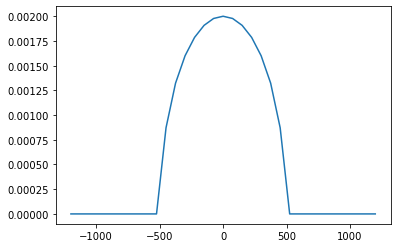

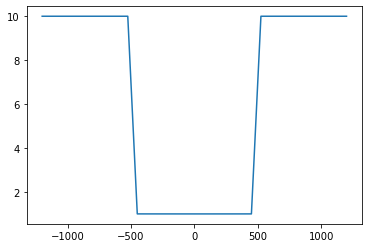

In [212]:
#Conditions initiales

x = np.arange(-L//2, L//2 + 1, deltaX)
d = 500 #largeur de la zone de glissemnt initiale

A = []
for y in x :
    if y < d and y > -d:
        A.append(np.sqrt(d**2 - y**2)/(d**2))
    else :
        A.append(v0)
        
B = []
for y in x :
    if y < d and y > -d:
        B.append((d**2 - np.sqrt(d**2 - y**2))/(d**2))
    else :
        B.append(10)
        
A = np.array(A)
B = np.array(B)
h = 1e-2

plt.plot(x, A)
plt.show()
plt.plot(x, B)
plt.show()

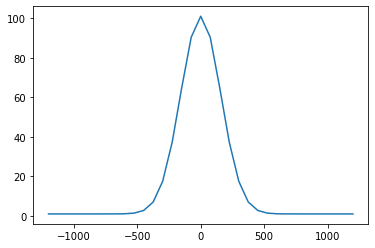

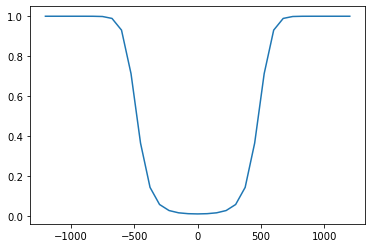

In [213]:
C = np.exp(-x**2/(d**2/5))*100 + np.ones(I+1)
plt.plot(x,C)
plt.show()

D = 1/C
plt.plot(x,D)
plt.show()

ykk=[[ 5.54565598e-04  5.55691812e-04  5.58073936e-04  5.62425983e-04
   5.76811640e-04  6.98491854e-04  1.88837000e-03  1.15754662e-02
   7.26432276e-02  3.39735566e-01  1.00955342e+00  1.94756456e+00
   2.86479902e+00  3.62049756e+00  4.17085088e+00  4.50322442e+00
   4.61421767e+00  4.50322442e+00  4.17085088e+00  3.62049756e+00
   2.86479902e+00  1.94756456e+00  1.00955342e+00  3.39735566e-01
   7.26432276e-02  1.15754662e-02  1.88837000e-03  6.98491854e-04
   5.76811640e-04  5.62425983e-04  5.58073936e-04  5.55691812e-04
   5.54565598e-04]
 [-2.76186746e-06 -2.76845737e-06 -2.80571416e-06 -3.35155509e-06
  -1.20403373e-05 -1.25369945e-04 -1.30281914e-03 -1.09705649e-02
  -7.20064374e-02 -3.39045552e-01 -1.00878475e+00 -1.94672056e+00
  -2.86398020e+00 -3.61993186e+00 -4.17076199e+00 -4.50361104e+00
  -4.61480125e+00 -4.50361104e+00 -4.17076199e+00 -3.61993186e+00
  -2.86398020e+00 -1.94672056e+00 -1.00878475e+00 -3.39045552e-01
  -7.20064374e-02 -1.09705649e-02 -1.30281914e-03 -1.

ykk=[[ 5.41185832e-03  5.42280217e-03  5.44583809e-03  5.48357539e-03
   5.54814102e-03  5.74313087e-03  7.04266719e-03  1.69012524e-02
   7.82599625e-02  3.45876429e-01  1.01663830e+00  1.95613601e+00
   2.87470248e+00  3.62866262e+00  4.17194860e+00  4.50597872e+00
   4.63449779e+00  4.50597872e+00  4.17194860e+00  3.62866262e+00
   2.87470248e+00  1.95613601e+00  1.01663830e+00  3.45876429e-01
   7.82599625e-02  1.69012524e-02  7.04266719e-03  5.74313087e-03
   5.54814102e-03  5.48357539e-03  5.44583809e-03  5.42280217e-03
   5.41185832e-03]
 [-2.49266381e-04 -2.49774332e-04 -2.50861039e-04 -2.53111499e-04
  -2.64352477e-04 -3.81450845e-04 -1.56477020e-03 -1.12437905e-02
  -7.23119526e-02 -3.39476154e-01 -1.00970579e+00 -1.94916600e+00
  -2.86918462e+00 -3.62578341e+00 -4.17138886e+00 -4.51724906e+00
  -4.66741869e+00 -4.51724906e+00 -4.17138886e+00 -3.62578341e+00
  -2.86918462e+00 -1.94916600e+00 -1.00970579e+00 -3.39476154e-01
  -7.23119526e-02 -1.12437905e-02 -1.56477020e-03 -3.

  -8.33384173e-04]]
ykk=[[ 8.55632526e-03  8.57367882e-03  8.61007078e-03  8.66959843e-03
   8.76663441e-03  9.00945754e-03  1.03801456e-02  2.03515014e-02
   8.19058606e-02  3.49901832e-01  1.02144124e+00  1.96236492e+00
   2.88229522e+00  3.63493751e+00  4.17318487e+00  4.49049080e+00
   4.61925180e+00  4.49049080e+00  4.17318487e+00  3.63493751e+00
   2.88229522e+00  1.96236492e+00  1.02144124e+00  3.49901832e-01
   8.19058606e-02  2.03515014e-02  1.03801456e-02  9.00945754e-03
   8.76663441e-03  8.66959843e-03  8.61007078e-03  8.57367882e-03
   8.55632526e-03]
 [-6.02726674e-04 -6.03953276e-04 -6.06547562e-04 -6.11241917e-04
  -6.26149550e-04 -7.48653101e-04 -1.94040106e-03 -1.16355484e-02
  -7.27496652e-02 -3.40090259e-01 -1.01099488e+00 -1.95239396e+00
  -2.87522901e+00 -3.63185112e+00 -4.17282695e+00 -4.49123162e+00
  -4.64481370e+00 -4.49123162e+00 -4.17282695e+00 -3.63185112e+00
  -2.87522901e+00 -1.95239396e+00 -1.01099488e+00 -3.40090259e-01
  -7.27496652e-02 -1.16355484e-02

  -1.24613075e-03]]
ykk=[[ 1.43514458e-02  1.43796813e-02  1.44422043e-02  1.45389179e-02
   1.46991260e-02  1.50244902e-02  1.65324434e-02  2.67037698e-02
   8.86412100e-02  3.57385552e-01  1.03063907e+00  1.97470677e+00
   2.89715194e+00  3.64604049e+00  4.17487114e+00  4.47915397e+00
   4.95180760e+00  4.47915397e+00  4.17487114e+00  3.64604049e+00
   2.89715194e+00  1.97470677e+00  1.03063907e+00  3.57385552e-01
   8.86412100e-02  2.67037698e-02  1.65324434e-02  1.50244902e-02
   1.46991260e-02  1.45389179e-02  1.44422043e-02  1.43796813e-02
   1.43514458e-02]
 [-1.60297475e-03 -1.60623015e-03 -1.61312173e-03 -1.62471834e-03
  -1.65007521e-03 -1.78785713e-03 -3.00358822e-03 -1.27442043e-02
  -7.39873485e-02 -3.41816807e-01 -1.01453754e+00 -1.96067026e+00
  -2.88871732e+00 -3.64299124e+00 -4.17476642e+00 -4.47899636e+00
  -5.31825005e+00 -4.47899636e+00 -4.17476642e+00 -3.64299124e+00
  -2.88871732e+00 -1.96067026e+00 -1.01453754e+00 -3.41816807e-01
  -7.39873485e-02 -1.27442043e-02

  -2.39040051e-03]]
ykk=[[ 1.49155713e-02  1.49461045e-02  1.50090367e-02  1.51133345e-02
   1.52750227e-02  1.56159916e-02  1.71291112e-02  2.73332243e-02
   8.92946561e-02  3.58139429e-01  1.03154871e+00  1.97599689e+00
   2.89861105e+00  3.64730870e+00  4.17488248e+00  4.48165480e+00
   4.60682048e+00  4.48165480e+00  4.17488248e+00  3.64730870e+00
   2.89861105e+00  1.97599689e+00  1.03154871e+00  3.58139429e-01
   8.92946561e-02  2.73332243e-02  1.71291112e-02  1.56159916e-02
   1.52750227e-02  1.51133345e-02  1.50090367e-02  1.49461045e-02
   1.49155713e-02]
 [-1.72127391e-03 -1.72478868e-03 -1.73215639e-03 -1.74463165e-03
  -1.77115445e-03 -1.91086297e-03 -3.12930765e-03 -1.28755021e-02
  -7.41335989e-02 -3.42020641e-01 -1.01494875e+00 -1.96159702e+00
  -2.89010507e+00 -3.64421196e+00 -4.17466894e+00 -4.48237792e+00
  -4.63537883e+00 -4.48237792e+00 -4.17466894e+00 -3.64421196e+00
  -2.89010507e+00 -1.96159702e+00 -1.01494875e+00 -3.42020641e-01
  -7.41335989e-02 -1.28755021e-02

  -2.74125171e-03]]
ykk=[[ 1.98922670e-02  1.99327046e-02  2.00171576e-02  2.01551901e-02
   2.03691443e-02  2.07845104e-02  2.24123441e-02  3.27962362e-02
   9.50928839e-02  3.64653988e-01  1.03975244e+00  1.98725178e+00
   2.91154546e+00  3.65640212e+00  4.17590436e+00  4.47393523e+00
   4.74375568e+00  4.47393523e+00  4.17590436e+00  3.65640212e+00
   2.91154546e+00  1.98725178e+00  1.03975244e+00  3.64653988e-01
   9.50928839e-02  3.27962362e-02  2.24123441e-02  2.07845104e-02
   2.03691443e-02  2.01551901e-02  2.00171576e-02  1.99327046e-02
   1.98922670e-02]
 [-2.92726604e-03 -2.93326753e-03 -2.94577685e-03 -2.96670722e-03
  -3.00574961e-03 -3.16414694e-03 -4.41137433e-03 -1.42126689e-02
  -7.56243001e-02 -3.44087269e-01 -1.01907310e+00 -1.97050197e+00
  -2.90266181e+00 -3.65341546e+00 -4.17571420e+00 -4.47423854e+00
  -4.91823825e+00 -4.47423854e+00 -4.17571420e+00 -3.65341546e+00
  -2.90266181e+00 -1.97050197e+00 -1.01907310e+00 -3.44087269e-01
  -7.56243001e-02 -1.42126689e-02

ykk=[[ 2.16891901e-02  2.17336956e-02  2.18250806e-02  2.19768701e-02
   2.22078669e-02  2.26531194e-02  2.43192161e-02  3.47736407e-02
   9.71879748e-02  3.67027965e-01  1.04276231e+00  1.99141190e+00
   2.91617590e+00  3.65965636e+00  4.17623157e+00  4.47288829e+00
   4.58550676e+00  4.47288829e+00  4.17623157e+00  3.65965636e+00
   2.91617590e+00  1.99141190e+00  1.04276231e+00  3.67027965e-01
   9.71879748e-02  3.47736407e-02  2.43192161e-02  2.26531194e-02
   2.22078669e-02  2.19768701e-02  2.18250806e-02  2.17336956e-02
   2.16891901e-02]
 [-3.42576428e-03 -3.43280522e-03 -3.44742751e-03 -3.47189061e-03
  -3.51608290e-03 -3.68228083e-03 -4.94136334e-03 -1.47655253e-02
  -7.62401495e-02 -3.44938281e-01 -1.02074633e+00 -1.97397083e+00
  -2.90723515e+00 -3.65668906e+00 -4.17605077e+00 -4.47365558e+00
  -4.60731821e+00 -4.47365558e+00 -4.17605077e+00 -3.65668906e+00
  -2.90723515e+00 -1.97397083e+00 -1.02074633e+00 -3.44938281e-01
  -7.62401495e-02 -1.47655253e-02 -4.94136334e-03 -3.

ykk=[[ 0.02795489  0.02801175  0.02813052  0.02832442  0.0286219   0.02916026
   0.03097244  0.04165474  0.10450865  0.37532522  1.05343522  2.00604326
   2.93207283  3.67020389  4.17723479  4.46331267  4.79986564  4.46331267
   4.17723479  3.67020389  2.93207283  2.00604326  1.05343522  0.37532522
   0.10450865  0.04165474  0.03097244  0.02916026  0.0286219   0.02832442
   0.02813052  0.02801175  0.02795489]
 [-0.0054045  -0.00541564 -0.00543874 -0.00547714 -0.00554198 -0.005739
  -0.0070455  -0.01696    -0.07868343 -0.34829933 -1.02724439 -1.98681326
  -2.92310682 -3.66736426 -4.17709247 -4.46328056 -5.04538755 -4.46328056
  -4.17709247 -3.66736426 -2.92310682 -1.98681326 -1.02724439 -0.34829933
  -0.07868343 -0.01696    -0.0070455  -0.005739   -0.00554198 -0.00547714
  -0.00543874 -0.00541564 -0.0054045 ]]
ykk=[[ 0.02622283  0.02627659  0.02638723  0.02657051  0.0268484   0.02736293
   0.02913256  0.03975502  0.10248259  0.37302958  1.05045967  2.00198892
   2.92772185  3.66742283  

  -0.0072188  -0.00718817 -0.00717331]]
ykk=[[ 0.02900477  0.02906419  0.02918671  0.02938923  0.02969603  0.03025296
   0.03208646  0.0428123   0.10573549  0.37673007  1.05524289  2.00852778
   2.93468568  3.67196802  4.17737445  4.46289135  4.67477806  4.46289135
   4.17737445  3.67196802  2.93468568  2.00852778  1.05524289  0.37673007
   0.10573549  0.0428123   0.03208646  0.03025296  0.02969603  0.02938923
   0.02918671  0.02906419  0.02900477]
 [-0.00576916 -0.00578105 -0.00580572 -0.00584669 -0.00591535 -0.00611804
  -0.00743332 -0.01736443 -0.0791335  -0.34891619 -1.02842009 -1.98904709
  -2.92573144 -3.66910079 -4.17723768 -4.46283053 -4.79917156 -4.46283053
  -4.17723768 -3.66910079 -2.92573144 -1.98904709 -1.02842009 -0.34891619
  -0.0791335  -0.01736443 -0.00743332 -0.00611804 -0.00591535 -0.00584669
  -0.00580572 -0.00578105 -0.00576916]]
ykk=[[ 0.03037011  0.03043198  0.03056089  0.03077185  0.03109404  0.03166988
   0.03353684  0.04431026  0.1073338   0.37854588  1.057606

  -0.0059745  -0.00594911 -0.00593687]]
ykk=[[ 0.0294786   0.02953908  0.02966345  0.02986958  0.03018092  0.03074571
   0.0325894   0.043334    0.10628953  0.37736333  1.056061    2.00964764
   2.93586121  3.67275585  4.1774356   4.4626868   4.65820607  4.4626868
   4.1774356   3.67275585  2.93586121  2.00964764  1.056061    0.37736333
   0.10628953  0.043334    0.0325894   0.03074571  0.03018092  0.02986958
   0.02966345  0.02953908  0.0294786 ]
 [-0.00593687 -0.00594912 -0.0059745  -0.00601666 -0.00608706 -0.00629239
  -0.00761169 -0.01755046 -0.07934047 -0.34919971 -1.02895875 -1.99006329
  -2.92691348 -3.66989298 -4.17730018 -4.46277685 -4.76736292 -4.46277685
  -4.17730018 -3.66989298 -2.92691348 -1.99006329 -1.02895875 -0.34919971
  -0.07934047 -0.01755046 -0.00761169 -0.00629239 -0.00608706 -0.00601666
  -0.0059745  -0.00594912 -0.00593687]]
ykk=[[ 0.02947859  0.02953907  0.02966345  0.02986957  0.03018091  0.0307457
   0.0325894   0.04333399  0.10628953  0.37736332  1.05606099

  -0.00695317 -0.00692363 -0.00690935]]
ykk=[[ 0.03233939  0.03240592  0.03254213  0.0327688   0.03310906  0.03371892
   0.03562693  0.04648083  0.10963752  0.3811879   1.06102511  2.01640558
   2.94290224  3.67739308  4.17779484  4.46025233  4.62230099  4.46025233
   4.17779484  3.67739308  2.94290224  2.01640558  1.06102511  0.3811879
   0.10963752  0.04648083  0.03562693  0.03371892  0.03310906  0.0327688
   0.03254213  0.03240592  0.03233939]
 [-0.00698859 -0.00700304 -0.00703292 -0.00708256 -0.00716392 -0.00738579
  -0.00873029 -0.01871722 -0.08063809 -0.35097474 -1.0323088  -1.99628003
  -2.93400419 -3.67459985 -4.17766533 -4.46085468 -4.70145911 -4.46085468
  -4.17766533 -3.67459985 -2.93400419 -1.99628003 -1.0323088  -0.35097474
  -0.08063809 -0.01871722 -0.00873029 -0.00738579 -0.00716392 -0.00708256
  -0.00703292 -0.00700304 -0.00698859]]
ykk=[[ 0.03216064  0.03222684  0.03236223  0.03258778  0.03292603  0.03353338
   0.03543704  0.04628463  0.10942811  0.38094938  1.0607136 

ykk=[[ 0.03488191  0.03495383  0.03510056  0.03534553  0.03571149  0.03636149
   0.03832676  0.04927824  0.11261542  0.38459729  1.0654661   2.02241657
   2.94907217  3.68140332  4.17809256  4.45784445  4.55923816  4.45784445
   4.17809256  3.68140332  2.94907217  2.02241657  1.0654661   0.38459729
   0.11261542  0.04927824  0.03832676  0.03636149  0.03571149  0.03534553
   0.03510056  0.03495383  0.03488191]
 [-0.00797656 -0.00799308 -0.00802718 -0.00808389 -0.00817555 -0.00841302
  -0.00978119 -0.01981341 -0.08185669 -0.35263758 -1.03541515 -2.00189592
  -2.94022922 -3.67866    -4.17796991 -4.45857151 -4.58047493 -4.45857151
  -4.17796991 -3.67866    -2.94022922 -2.00189592 -1.03541515 -0.35263758
  -0.08185669 -0.01981341 -0.00978119 -0.00841302 -0.00817555 -0.00808389
  -0.00802718 -0.00799308 -0.00797656]]
ykk=[[ 0.03842391  0.03850043  0.03866686  0.03892805  0.03934087  0.04002913
   0.04209367  0.05315073  0.11677518  0.38931467  1.07170834  2.03068538
   2.95755569  3.68638031

  -0.00953528 -0.00949471 -0.00947506]]
ykk=[[ 0.04123297  0.04131471  0.04149404  0.04177309  0.04221711  0.04294528
   0.04507811  0.05623589  0.12007191  0.39309096  1.07667615  2.0372671
   2.96415052  3.69038369  4.17868727  4.44446388  4.66793695  4.44446388
   4.17868727  3.69038369  2.96415052  2.0372671   1.07667615  0.39309096
   0.12007191  0.05623589  0.04507811  0.04294528  0.04221711  0.04177309
   0.04149404  0.04131471  0.04123297]
 [-0.01065438 -0.01067643 -0.01072221 -0.01079774 -0.01091784 -0.01119702
  -0.01263032 -0.02278406 -0.08515837 -0.35712164 -1.04366217 -2.01617733
  -2.95548178 -3.6879397  -4.17860964 -4.44539982 -4.79140802 -4.44539982
  -4.17860964 -3.6879397  -2.95548178 -2.01617733 -1.04366217 -0.35712164
  -0.08515837 -0.02278406 -0.01263032 -0.01119702 -0.01091784 -0.01079774
  -0.01072221 -0.01067643 -0.01065438]]
ykk=[[ 0.03960486  0.03968433  0.03985488  0.04012599  0.04054907  0.04125872
   0.04334693  0.05445432  0.11815887  0.39091329  1.0737898

ykk=[[ 0.03970533  0.03978503  0.03995597  0.04022786  0.04065189  0.04136322
   0.04345359  0.05456503  0.11827667  0.391049    1.0739673   2.03371519
   2.96056948  3.68829605  4.17858066  4.44673132  4.67638132  4.44673132
   4.17858066  3.68829605  2.96056948  2.03371519  1.0739673   0.391049
   0.11827667  0.05456503  0.04345359  0.04136322  0.04065189  0.04022786
   0.03995597  0.03978503  0.03970533]
 [-0.00998424 -0.01000492 -0.01004775 -0.01011861 -0.01023152 -0.01050035
  -0.01191721 -0.02204073 -0.08433226 -0.35600249 -1.04162023 -2.01271853
  -2.95185419 -3.68572917 -4.17848581 -4.44605282 -4.81161818 -4.44605282
  -4.17848581 -3.68572917 -2.95185419 -2.01271853 -1.04162023 -0.35600249
  -0.08433226 -0.02204073 -0.01191721 -0.01050035 -0.01023152 -0.01011861
  -0.01004775 -0.01000492 -0.00998424]]
ykk=[[ 0.03970533  0.03978503  0.03995597  0.04022786  0.04065189  0.04136322
   0.04345359  0.05456503  0.11827667  0.391049    1.0739673   2.03371519
   2.96056948  3.68829605  

  -0.01118536 -0.01113756 -0.01111457]]
ykk=[[ 0.04227231  0.04235765  0.04253888  0.04282989  0.04327918  0.04403231
   0.04617938  0.05739225  0.12128798  0.39451748  1.07851053  2.03975235
   2.9665525   3.69206332  4.17875555  4.44587033  4.60475666  4.44587033
   4.17875555  3.69206332  2.9665525   2.03975235  1.07851053  0.39451748
   0.12128798  0.05739225  0.04617938  0.04403231  0.04327918  0.04282989
   0.04253888  0.04235765  0.04227231]
 [-0.01111462 -0.01113761 -0.01118541 -0.01126417 -0.01138919 -0.01167552
  -0.01312009 -0.02329465 -0.08572564 -0.35788946 -1.04505655 -2.01851641
  -2.95791014 -3.68947334 -4.17868142 -4.44617485 -4.67421169 -4.44617485
  -4.17868142 -3.68947334 -2.95791014 -2.01851641 -1.04505655 -0.35788946
  -0.08572564 -0.02329465 -0.01312009 -0.01167552 -0.01138919 -0.01126417
  -0.01118541 -0.01113761 -0.01111462]]
ykk=[[ 0.04486614  0.04495703  0.04514894  0.0454588   0.04593423  0.04672873
   0.04893424  0.06024831  0.12433319  0.39802737  1.083118

ykk=[[ 0.04505529  0.04514657  0.04533928  0.04565047  0.04612786  0.04692529
   0.04913517  0.06045648  0.12455537  0.39828336  1.08345566  2.04627193
   2.97295155  3.69606395  4.17892552  4.44383523  4.55157799  4.44383523
   4.17892552  3.69606395  2.97295155  2.04627193  1.08345566  0.39828336
   0.12455537  0.06045648  0.04913517  0.04692529  0.04612786  0.04565047
   0.04533928  0.04514657  0.04505529]
 [-0.01238809 -0.01241371 -0.01246711 -0.01255481 -0.01269345 -0.01299963
  -0.01447535 -0.02470759 -0.08729498 -0.36001026 -1.04888273 -2.02483736
  -2.96438842 -3.69349536 -4.17885891 -4.44442582 -4.57316206 -4.44442582
  -4.17885891 -3.69349536 -2.96438842 -2.02483736 -1.04888273 -0.36001026
  -0.08729498 -0.02470759 -0.01447535 -0.01299963 -0.01269345 -0.01255481
  -0.01246711 -0.01241371 -0.01238809]]
ykk=[[ 0.04900833  0.04910479  0.0493195   0.04964894  0.05017867  0.05101918
   0.05334024  0.06478143  0.12920887  0.4035936   1.09052611  2.05537717
   2.98191379  3.70108459

ykk=[[ 0.05033807  0.05043798  0.05065712  0.05099816  0.05153902  0.05240444
   0.05475152  0.0662513   0.13077019  0.40540997  1.09290003  2.0584755
   2.98487126  3.70292622  4.17919299  4.43291294  4.66038111  4.43291294
   4.17919299  3.70292622  2.98487126  2.0584755   1.09290003  0.40540997
   0.13077019  0.0662513   0.05475152  0.05240444  0.05153902  0.05099816
   0.05065712  0.05043798  0.05033807]
 [-0.01493944 -0.01497029 -0.01503501 -0.01514051 -0.01530673 -0.01565245
  -0.01719112 -0.02753837 -0.09043814 -0.36424213 -1.05641806 -2.0368877
  -2.9764653  -3.70051524 -4.17915986 -4.4323504  -4.78685067 -4.4323504
  -4.17915986 -3.70051524 -2.9764653  -2.0368877  -1.05641806 -0.36424213
  -0.09043814 -0.02753837 -0.01719112 -0.01565245 -0.01530673 -0.01514051
  -0.01503501 -0.01497029 -0.01493944]]
ykk=[[ 0.05167272  0.0517757   0.05199997  0.05235142  0.05290494  0.05379301
   0.05616883  0.06772337  0.13233881  0.40722852  1.09528773  2.06156695
   2.98782371  3.70474237  4

ykk=[[ 0.053152    0.05325811  0.05348856  0.05385064  0.05441927  0.05533075
   0.05774035  0.06935266  0.13407872  0.40924144  1.09793873  2.06497598
   2.99107623  3.70671093  4.17924618  4.43208871  4.59718303  4.43208871
   4.17924618  3.70671093  2.99107623  2.06497598  1.09793873  0.40924144
   0.13407872  0.06935266  0.05774035  0.05533075  0.05441927  0.05385064
   0.05348856  0.05325811  0.053152  ]
 [-0.01635957 -0.0163933  -0.0164644  -0.01657974 -0.01676146 -0.01712906
  -0.01870308 -0.02911401 -0.09218717 -0.36658847 -1.06054342 -2.04328827
  -2.98275274 -3.70427191 -4.17922476 -4.43235443 -4.66645906 -4.43235443
  -4.17922476 -3.70427191 -2.98275274 -2.04328827 -1.06054342 -0.36658847
  -0.09218717 -0.02911401 -0.01870308 -0.01712906 -0.01676146 -0.01657974
  -0.0164644  -0.0163933  -0.01635957]]
ykk=[[ 0.05315159  0.0532577   0.05348815  0.05385023  0.05441885  0.05533032
   0.05773991  0.06935221  0.13407824  0.40924088  1.097938    2.06497505
   2.99107534  3.7067104 

ykk=[[ 0.05660987  0.05672339  0.05696815  0.05735541  0.05795908  0.05892588
   0.06141401  0.0731627   0.13814774  0.41395526  1.10414533  2.07291125
   2.99858998  3.71125926  4.17930334  4.42984927  4.5623411   4.42984927
   4.17930334  3.71125926  2.99858998  2.07291125  1.10414533  0.41395526
   0.13814774  0.0731627   0.06141401  0.05892588  0.05795908  0.05735541
   0.05696815  0.05672339  0.05660987]
 [-0.01816284 -0.01820026 -0.01827943 -0.01840736 -0.01860872 -0.01900432
  -0.02062314 -0.03111524 -0.09440746 -0.36956039 -1.06571636 -2.05115394
  -2.9903645  -3.70884477 -4.17928474 -4.43032196 -4.60286458 -4.43032196
  -4.17928474 -3.70884477 -2.9903645  -2.05115394 -1.06571636 -0.36956039
  -0.09440746 -0.03111524 -0.02062314 -0.01900432 -0.01860872 -0.01840736
  -0.01827943 -0.01820026 -0.01816284]]
ykk=[[ 0.05788375  0.05799959  0.05825035  0.05864555  0.05926374  0.06024839
   0.06276829  0.07456289  0.13964859  0.41568746  1.10643728  2.07580677
   3.00133076  3.71284127

  -0.02020601 -0.02011827 -0.02007691]]
ykk=[[ 0.06015899  0.06027996  0.06053972  0.06095234  0.06159266  0.06261537
   0.06518538  0.07707283  0.14232741  0.41880029  1.11052836  2.08099224
   3.00617838  3.71577244  4.17934954  4.42688572  4.59972159  4.42688572
   4.17934954  3.71577244  3.00617838  2.08099224  1.11052836  0.41880029
   0.14232741  0.07707283  0.06518538  0.06261537  0.06159266  0.06095234
   0.06053972  0.06027996  0.06015899]
 [-0.02007691 -0.02011827 -0.02020601 -0.02034736 -0.02056958 -0.02099503
  -0.02266145 -0.03323985 -0.09676355 -0.37270588 -1.07113278 -2.05920952
  -2.99805121 -3.7133859  -4.1793361  -4.42715507 -4.6829017  -4.42715507
  -4.1793361  -3.7133859  -2.99805121 -2.05920952 -1.07113278 -0.37270588
  -0.09676355 -0.03323985 -0.02266145 -0.02099503 -0.02056958 -0.02034736
  -0.02020601 -0.02011827 -0.02007691]]
ykk=[[ 0.06015899  0.06027996  0.06053973  0.06095234  0.06159266  0.06261537
   0.06518538  0.07707283  0.14232741  0.41880029  1.110528

  -0.02238964 -0.02229222 -0.02224636]]
ykk=[[ 0.0637621   0.06389078  0.06416557  0.06460439  0.06528151  0.06636187
   0.0690144   0.08104462  0.14657324  0.42373018  1.11701672  2.08914067
   3.01375897  3.72028605  4.17938768  4.42459426  4.57260295  4.42459426
   4.17938768  3.72028605  3.01375897  2.08914067  1.11701672  0.42373018
   0.14657324  0.08104462  0.0690144   0.06636187  0.06528151  0.06460439
   0.06416557  0.06389078  0.0637621 ]
 [-0.02208155 -0.02212707 -0.02222376 -0.02237931 -0.02262332 -0.0230803
  -0.02479649 -0.03546564 -0.09923047 -0.37599138 -1.07672907 -2.0673635
  -3.00572853 -3.71795101 -4.17937533 -4.42503779 -4.6345185  -4.42503779
  -4.17937533 -3.71795101 -3.00572853 -2.0673635  -1.07672907 -0.37599138
  -0.09923047 -0.03546564 -0.02479649 -0.0230803  -0.02262332 -0.02237931
  -0.02222376 -0.02212707 -0.02208155]]
ykk=[[ 0.06403941  0.06416862  0.06444469  0.06488531  0.06556552  0.06664991
   0.06930925  0.08134975  0.14690032  0.42410887  1.11751677

ykk=[[ 0.06776246  0.06789961  0.0681913   0.06865895  0.06937739  0.07052129
   0.07326635  0.08545462  0.15129067  0.42921167  1.12422778  2.09810928
   3.02203804  3.72513898  4.1794223   4.42173247  4.57448858  4.42173247
   4.1794223   3.72513898  3.02203804  2.09810928  1.12422778  0.42921167
   0.15129067  0.08545462  0.07326635  0.07052129  0.06937739  0.06865895
   0.0681913   0.06789961  0.06776246]
 [-0.02437649 -0.0244268  -0.02453373 -0.02470562 -0.02497458 -0.02546788
  -0.02724107 -0.03801437 -0.10205391 -0.37974179 -1.08304655 -2.07637526
  -3.01411247 -3.72285955 -4.17941213 -4.42217251 -4.64411405 -4.42217251
  -4.17941213 -3.72285955 -3.01411247 -2.07637526 -1.08304655 -0.37974179
  -0.10205391 -0.03801437 -0.02724107 -0.02546788 -0.02497458 -0.02470562
  -0.02453373 -0.0244268  -0.02437649]]
ykk=[[ 0.06784894  0.06798626  0.06827835  0.06874656  0.06946597  0.07061113
   0.07335832  0.0855498   0.15139274  0.42932997  1.12438384  2.09830165
   3.0222156   3.72523937

  -0.0271529  -0.02703437 -0.02697858]]
ykk=[[ 0.07166003  0.07180547  0.07211362  0.07260947  0.0733682   0.07457426
   0.07740962  0.08975265  0.15588995  0.43456147  1.13125688  2.10677117
   3.0299708   3.72973638  4.17944669  4.41908336  4.55640867  4.41908336
   4.17944669  3.72973638  3.0299708   2.10677117  1.13125688  0.43456147
   0.15588995  0.08975265  0.07740962  0.07457426  0.0733682   0.07260947
   0.07211362  0.07180547  0.07166003]
 [-0.0266786  -0.02673375 -0.02685094 -0.02703933 -0.02733332 -0.02786326
  -0.02969368 -0.04057172 -0.1048855  -0.38349291 -1.08929466 -2.08510509
  -3.02214504 -3.72750486 -4.17943933 -4.41953345 -4.61356443 -4.41953345
  -4.17943933 -3.72750486 -3.02214504 -2.08510509 -1.08929466 -0.38349291
  -0.1048855  -0.04057172 -0.02969368 -0.02786326 -0.02733332 -0.02703933
  -0.02685094 -0.02673375 -0.0266786 ]]
ykk=[[ 0.07215876  0.07230514  0.0726156   0.07311468  0.07387902  0.07509231
   0.07794005  0.09030165  0.15647899  0.43524468  1.132157

  -0.02933959 -0.02921137 -0.02915098]]
ykk=[[ 0.07569123  0.07584522  0.07617051  0.07669543  0.07749609  0.0787663
   0.08169564  0.09419884  0.16065009  0.44010224  1.13852756  2.11564789
   3.03804321  3.73435151  4.17946117  4.41631428  4.56329558  4.41631428
   4.17946117  3.73435151  3.03804321  2.11564789  1.13852756  0.44010224
   0.16065009  0.09419884  0.08169564  0.0787663   0.07749609  0.07669543
   0.07617051  0.07584522  0.07569123]
 [-0.02912484 -0.02918517 -0.02931327 -0.02951928 -0.02983991 -0.03040897
  -0.03230028 -0.04328985 -0.10789373 -0.38746737 -1.09584274 -2.09407544
  -3.03031861 -3.73216656 -4.17945706 -4.41675253 -4.63275119 -4.41675253
  -4.17945706 -3.73216656 -3.03031861 -2.09407544 -1.09584274 -0.38746737
  -0.10789373 -0.04328985 -0.03230028 -0.03040897 -0.02983991 -0.02951928
  -0.02931327 -0.02918517 -0.02912484]]
ykk=[[ 0.0757274   0.07588145  0.07620691  0.07673206  0.07753313  0.07880387
   0.0817341   0.09423867  0.16069283  0.44015186  1.1385928

  -0.03481871 -0.03466612 -0.03459417]]
ykk=[[ 0.07895656  0.07911755  0.07945662  0.08000539  0.08083978  0.08216257
   0.08516768  0.09780192  0.16450786  0.4445973   1.14441477  2.12278166
   3.04448674  3.73801479  4.17946658  4.41439007  4.51151562  4.41439007
   4.17946658  3.73801479  3.04448674  2.12278166  1.14441477  0.4445973
   0.16450786  0.09780192  0.08516768  0.08216257  0.08083978  0.08000539
   0.07945662  0.07911755  0.07895656]
 [-0.03115229 -0.03121692 -0.03135407 -0.03157477 -0.03191748 -0.03251913
  -0.03446096 -0.04554317 -0.11038648 -0.39075295 -1.10120281 -2.10129498
  -3.03684229 -3.73586378 -4.17946459 -4.4149057  -4.53388395 -4.4149057
  -4.17946459 -3.73586378 -3.03684229 -2.10129498 -1.10120281 -0.39075295
  -0.11038648 -0.04554317 -0.03446096 -0.03251913 -0.03191748 -0.03157477
  -0.03135407 -0.03121692 -0.03115229]]
ykk=[[ 0.08464855  0.08481688  0.08518852  0.08576325  0.08667522  0.08805991
   0.09123036  0.10404171  0.17125071  0.45236553  1.15469828

  -0.03677502 -0.03661346 -0.0365375 ]]
ykk=[[ 0.08733365  0.08750834  0.08789028  0.08848653  0.08942402  0.09085563
   0.0940846   0.10701055  0.17442401  0.45607828  1.15952418  2.14066997
   3.06066603  3.7461719   4.17939758  4.39914084  4.57252596  4.39914084
   4.17939758  3.7461719   3.06066603  2.14066997  1.15952418  0.45607828
   0.17442401  0.10701055  0.0940846   0.09085563  0.08942402  0.08848653
   0.08789028  0.08750834  0.08733365]
 [-0.03654305 -0.03661903 -0.03678061 -0.03704    -0.03744229 -0.03813001
  -0.04020779 -0.0515349  -0.11701322 -0.39944886 -1.11518343 -2.11959542
  -3.0532348  -3.74419518 -4.17943989 -4.39823129 -4.6453187  -4.39823129
  -4.17943989 -3.74419518 -3.0532348  -2.11959542 -1.11518343 -0.39944886
  -0.11701322 -0.0515349  -0.04020779 -0.03813001 -0.03744229 -0.03704
  -0.03678061 -0.03661903 -0.03654305]]
ykk=[[ 0.08732796  0.08750263  0.08788454  0.08848076  0.08941819  0.09084971
   0.09407854  0.10700427  0.17441727  0.45607043  1.15951394 

ykk=[[ 0.09067403  0.09085607  0.09125186  0.09187312  0.09284462  0.09433125
   0.09763709  0.11069996  0.17837539  0.46069222  1.16552638  2.14776127
   3.06695207  3.74962684  4.17925588  4.39888577  4.51823942  4.39888577
   4.17925588  3.74962684  3.06695207  2.14776127  1.16552638  0.46069222
   0.17837539  0.11069996  0.09763709  0.09433125  0.09284462  0.09187312
   0.09125186  0.09085607  0.09067403]
 [-0.03875415 -0.03883472 -0.0390065  -0.03928158 -0.03970868 -0.04043141
  -0.04256566 -0.05399258 -0.11973078 -0.40299948 -1.1208115  -2.12677361
  -3.05960361 -3.74761697 -4.17930969 -4.39902601 -4.54209894 -4.39902601
  -4.17930969 -3.74761697 -3.05960361 -2.12677361 -1.1208115  -0.40299948
  -0.11973078 -0.05399258 -0.04256566 -0.04043141 -0.03970868 -0.03928158
  -0.0390065  -0.03883472 -0.03875415]]
ykk=[[ 0.10114599  0.10134334  0.10179622  0.10247109  0.10357924  0.10519125
   0.10879136  0.1222026   0.19079511  0.47505406  1.18433847  2.16941005
   3.08624179  3.75721125

ykk=[[ 0.09691853  0.0971138   0.09753651  0.09820286  0.09924026  0.10082666
   0.10428044  0.11759439  0.18576855  0.46931842  1.17673067  2.16086915
   3.07850248  3.75587918  4.17900534  4.39530472  4.62201981  4.39530472
   4.17900534  3.75587918  3.07850248  2.16086915  1.17673067  0.46931842
   0.18576855  0.11759439  0.10428044  0.10082666  0.09924026  0.09820286
   0.09753651  0.0971138   0.09691853]
 [-0.04298425 -0.04307369 -0.04326492 -0.04357029 -0.04404483 -0.0448351
  -0.04707738 -0.05869602 -0.12492867 -0.40977166 -1.13141928 -2.14008728
  -3.07129948 -3.75391271 -4.17905489 -4.39539449 -4.75661184 -4.39539449
  -4.17905489 -3.75391271 -3.07129948 -2.14008728 -1.13141928 -0.40977166
  -0.12492867 -0.05869602 -0.04707738 -0.0448351  -0.04404483 -0.04357029
  -0.04326492 -0.04307369 -0.04298425]]
ykk=[[ 0.09596165  0.09615507  0.09657334  0.09723333  0.09825995  0.09983212
   0.103262    0.11653928  0.18463477  0.46799866  1.17501459  2.15887775
   3.07674819  3.75496551 

ykk=[[ 0.10166112  0.10186431  0.10231124  0.10300502  0.10410076  0.10575001
   0.10933089  0.12281342  0.19139305  0.47584215  1.18523182  2.17062828
   3.08711504  3.76003074  4.1788182   4.38662885  4.63423567  4.38662885
   4.1788182   3.76003074  3.08711504  2.17062828  1.18523182  0.47584215
   0.19139305  0.12281342  0.10933089  0.10575001  0.10410076  0.10300502
   0.10231124  0.10186431  0.10166112]
 [-0.04628202 -0.04637836 -0.04658488 -0.04691385 -0.04742565 -0.04826856
  -0.05059563 -0.06236354 -0.12898026 -0.41503141 -1.13955323 -2.15009425
  -3.08002267 -3.75814603 -4.1788798  -4.3851156  -4.77508613 -4.3851156
  -4.1788798  -3.75814603 -3.08002267 -2.15009425 -1.13955323 -0.41503141
  -0.12898026 -0.06236354 -0.05059563 -0.04826856 -0.04742565 -0.04691385
  -0.04658488 -0.04637836 -0.04628202]]
ykk=[[ 0.10166679  0.10186999  0.10231694  0.10301077  0.10410656  0.10575591
   0.10933692  0.12281969  0.19139976  0.47585     1.18524195  2.17063998
   3.08712521  3.76003622 

  -0.04907873 -0.04886066 -0.04875914]]
ykk=[[ 0.10466158  0.10487163  0.10533071  0.10604777  0.10717347  0.10887381
   0.11252294  0.12613203  0.19494771  0.48000105  1.1905887   2.1768117
   3.09247447  3.76293504  4.17864797  4.38741988  4.54812445  4.38741988
   4.17864797  3.76293504  3.09247447  2.1768117   1.1905887   0.48000105
   0.19494771  0.12613203  0.11252294  0.10887381  0.10717347  0.10604777
   0.10533071  0.10487163  0.10466158]
 [-0.04839604 -0.0484968  -0.04871318 -0.04905725 -0.04959307 -0.05046971
  -0.05285138 -0.06471489 -0.13157722 -0.41839439 -1.14470835 -2.15635798
  -3.08545005 -3.76102234 -4.17872113 -4.38718023 -4.60849454 -4.38718023
  -4.17872113 -3.76102234 -3.08545005 -2.15635798 -1.14470835 -0.41839439
  -0.13157722 -0.06471489 -0.05285138 -0.05046971 -0.04959307 -0.04905725
  -0.04871318 -0.0484968  -0.04839604]]
ykk=[[ 0.10500024  0.10521098  0.10567157  0.106391    0.1075204   0.109226
   0.1128834   0.1265059   0.19534923  0.48046926  1.19119331 

  -0.05342883 -0.05319067 -0.05308002]]
ykk=[[ 0.10863042  0.10884922  0.10932499  0.11007183  0.11123854  0.11300455
   0.11674646  0.13051984  0.19965267  0.48550022  1.19766413  2.18492682
   3.09948335  3.7666868   4.17843758  4.38652345  4.51131376  4.38652345
   4.17843758  3.7666868   3.09948335  2.18492682  1.19766413  0.48550022
   0.19965267  0.13051984  0.11674646  0.11300455  0.11123854  0.11007183
   0.10932499  0.10884922  0.10863042]
 [-0.05123123 -0.05133797 -0.05156752 -0.05193201 -0.05249998 -0.0534222
  -0.05587705 -0.06786926 -0.1350596  -0.4228956  -1.15155269 -2.16460092
  -3.09254451 -3.76479797 -4.17850654 -4.38672431 -4.54051356 -4.38672431
  -4.17850654 -3.76479797 -3.09254451 -2.16460092 -1.15155269 -0.4228956
  -0.1350596  -0.06786926 -0.05587705 -0.0534222  -0.05249998 -0.05193201
  -0.05156752 -0.05133797 -0.05123123]]
ykk=[[ 0.11179447  0.11201879  0.11251043  0.11327635  0.11448139  0.11629089
   0.12011677  0.13400585  0.20340915  0.48986313  1.20330235

ykk=[[ 0.11573173  0.11596002  0.11647653  0.11725694  0.11852088  0.12036688
   0.12431705  0.13831962  0.20809418  0.49524915  1.21032228  2.19907833
   3.11184028  3.77193431  4.17824529  4.36357367  4.37896656  4.36357367
   4.17824529  3.77193431  3.11184028  2.19907833  1.21032228  0.49524915
   0.20809418  0.13831962  0.12431705  0.12036688  0.11852088  0.11725694
   0.11647653  0.11596002  0.11573173]
 [-0.05642668 -0.05654444 -0.05679819 -0.05720035 -0.05782733 -0.05883361
  -0.06142283 -0.07365165 -0.14143996 -0.43111678 -1.16390032 -2.17924634
  -3.10505164 -3.77024855 -4.17834645 -4.3562882  -4.25379174 -4.3562882
  -4.17834645 -3.77024855 -3.10505164 -2.17924634 -1.16390032 -0.43111678
  -0.14143996 -0.07365165 -0.06142283 -0.05883361 -0.05782733 -0.05720035
  -0.05679819 -0.05654444 -0.05642668]]
ykk=[[ 0.1081895   0.10840735  0.10888121  0.10962483  0.11078688  0.11254575
   0.11627716  0.13003255  0.19912978  0.48488955  1.19687865  2.18402923
   3.09870908  3.76627852 

  -0.05595853 -0.0557086  -0.05559265]]
ykk=[[ 0.11460056  0.11483028  0.11533515  0.11611962  0.11735678  0.11920798
   0.12310507  0.13710232  0.20674018  0.49374152  1.20829084  2.19693137
   3.10986514  3.77172172  4.17814595  4.37901245  4.61842727  4.37901245
   4.17814595  3.77172172  3.10986514  2.19693137  1.20829084  0.49374152
   0.20674018  0.13710232  0.12310507  0.11920798  0.11735678  0.11611962
   0.11533515  0.11483028  0.11460056]
 [-0.05558117 -0.05569709 -0.05594698 -0.05634284 -0.05696038 -0.05795266
  -0.06052028 -0.07271004 -0.14040182 -0.4297801  -1.16190749 -2.1768923
  -3.1030554  -3.76993386 -4.17822909 -4.37837506 -4.7513708  -4.37837506
  -4.17822909 -3.76993386 -3.1030554  -2.1768923  -1.16190749 -0.4297801
  -0.14040182 -0.07271004 -0.06052028 -0.05795266 -0.05696038 -0.05634284
  -0.05594698 -0.05569709 -0.05558117]]
ykk=[[ 0.11460704  0.11483678  0.11534167  0.1161262   0.11736342  0.11921473
   0.12311197  0.13710949  0.20674787  0.49375052  1.20830234

  -0.05595035 -0.05570045 -0.05558453]]
ykk=[[ 0.11460512  0.11483486  0.11533974  0.11612425  0.11736145  0.11921273
   0.12310992  0.13710736  0.20674559  0.49374785  1.20829893  2.19694055
   3.10987298  3.77172582  4.17814565  4.37901325  4.61845034  4.37901325
   4.17814565  3.77172582  3.10987298  2.19694055  1.20829893  0.49374785
   0.20674559  0.13710736  0.12310992  0.11921273  0.11736145  0.11612425
   0.11533974  0.11483486  0.11460512]
 [-0.05558453 -0.05570045 -0.05595035 -0.05634624 -0.05696382 -0.05795615
  -0.06052386 -0.07271377 -0.14040594 -0.42978539 -1.1619154  -2.17690161
  -3.10306334 -3.76993789 -4.17822881 -4.37837729 -4.7514249  -4.37837729
  -4.17822881 -3.76993789 -3.10306334 -2.17690161 -1.1619154  -0.42978539
  -0.14040594 -0.07271377 -0.06052386 -0.05795615 -0.05696382 -0.05634624
  -0.05595035 -0.05570045 -0.05558453]]
ykk=[[ 0.11460512  0.11483486  0.11533974  0.11612425  0.11736145  0.11921273
   0.12310992  0.13710736  0.20674559  0.49374785  1.208298

  -0.05849663 -0.05823486 -0.05811359]]
ykk=[[ 0.11802405  0.11826156  0.11878053  0.11959144  0.12086339  0.12277275
   0.12674901  0.14089106  0.21080214  0.49849361  1.21435881  2.20380105
   3.1157152   3.77480021  4.17793638  4.37906598  4.55072442  4.37906598
   4.17793638  3.77480021  3.1157152   2.20380105  1.21435881  0.49849361
   0.21080214  0.14089106  0.12674901  0.12277275  0.12086339  0.11959144
   0.11878053  0.11826156  0.11802405]
 [-0.05811104 -0.0582323  -0.05849406 -0.05890819 -0.05955469 -0.0605878
  -0.06322127 -0.07552597 -0.1435084  -0.43377245 -1.16785217 -2.18386303
  -3.1089764  -3.77299364 -4.17801781 -4.37903965 -4.62169728 -4.37903965
  -4.17801781 -3.77299364 -3.1089764  -2.18386303 -1.16785217 -0.43377245
  -0.1435084  -0.07552597 -0.06322127 -0.0605878  -0.05955469 -0.05890819
  -0.05849406 -0.0582323  -0.05811104]]
ykk=[[ 0.11802656  0.11826407  0.11878305  0.11959398  0.12086596  0.12277536
   0.12675167  0.14089383  0.21080512  0.49849708  1.2143632

  -0.06424116 -0.06395266 -0.06381922]]
ykk=[[ 0.12174405  0.12198984  0.12252449  0.12336363  0.12467413  0.12664576
   0.13070946  0.14500742  0.21521822  0.50365672  1.2209394   2.21121372
   3.12200217  3.77808167  4.17772967  4.37830982  4.49873761  4.37830982
   4.17772967  3.77808167  3.12200217  2.21121372  1.2209394   0.50365672
   0.21521822  0.14500742  0.13070946  0.12664576  0.12467413  0.12336363
   0.12252449  0.12198984  0.12174405]
 [-0.06089239 -0.06101958 -0.06129436 -0.06172874 -0.06240702 -0.06348534
  -0.06619117 -0.07862272 -0.14692341 -0.43815321 -1.17432501 -2.19139808
  -3.11533753 -3.77629428 -4.1778039  -4.37849381 -4.52297316 -4.37849381
  -4.1778039  -3.77629428 -3.11533753 -2.19139808 -1.17432501 -0.43815321
  -0.14692341 -0.07862272 -0.06619117 -0.06348534 -0.06240702 -0.06172874
  -0.06129436 -0.06101958 -0.06089239]]
ykk=[[ 0.12923664  0.12949292  0.13007014  0.13094622  0.13235852  0.1344177
   0.13870029  0.15324685  0.22413621  0.51396238  1.2341843

  -0.06553615 -0.06524157 -0.0651054 ]]
ykk=[[ 0.12729282  0.12754956  0.12811016  0.12898683  0.13036051  0.13241637
   0.13662063  0.15113638  0.22181241  0.51133796  1.2307347   2.22212313
   3.1312526   3.7825589   4.17744695  4.37304253  4.61760054  4.37304253
   4.17744695  3.7825589   3.1312526   2.22212313  1.2307347   0.51133796
   0.22181241  0.15113638  0.13662063  0.13241637  0.13036051  0.12898683
   0.12811016  0.12754956  0.12729282]
 [-0.06510515 -0.06524132 -0.0655359  -0.06600103 -0.06672762 -0.06787462
  -0.07069041 -0.08331432 -0.15209538 -0.44477051 -1.18400972 -2.20254937
  -3.12469832 -3.78083352 -4.17752161 -4.37239336 -4.76089762 -4.37239336
  -4.17752161 -3.78083352 -3.12469832 -2.20254937 -1.18400972 -0.44477051
  -0.15209538 -0.08331432 -0.07069041 -0.06787462 -0.06672762 -0.06600103
  -0.0655359  -0.06524132 -0.06510515]]
ykk=[[ 0.12729295  0.12754969  0.12811029  0.12898696  0.13036065  0.13241651
   0.13662077  0.15113652  0.22181256  0.51133814  1.230734

  -0.06807213 -0.06776571 -0.06762413]]
ykk=[[ 0.13075153  0.13101616  0.13159114  0.13249465  0.13390379  0.13601877
   0.14030381  0.15496704  0.22592162  0.51614441  1.23681653  2.22890496
   3.1369322   3.78548778  4.17725933  4.37317228  4.54592076  4.37317228
   4.17725933  3.78548778  3.1369322   2.22890496  1.23681653  0.51614441
   0.22592162  0.15496704  0.14030381  0.13601877  0.13390379  0.13249465
   0.13159114  0.13101616  0.13075153]
 [-0.06776197 -0.06790385 -0.06821091 -0.06869554 -0.06945264 -0.07064318
  -0.07352844 -0.08627398 -0.1553568  -0.44893338 -1.19004673 -2.209439
  -3.13044423 -3.78376262 -4.1773332  -4.37312312 -4.62304301 -4.37312312
  -4.1773332  -3.78376262 -3.13044423 -2.209439   -1.19004673 -0.44893338
  -0.1553568  -0.08627398 -0.07352844 -0.07064318 -0.06945264 -0.06869554
  -0.06821091 -0.06790385 -0.06776197]]
ykk=[[ 0.13062466  0.13088904  0.13146344  0.13236606  0.13377378  0.13588677
   0.14016865  0.15482676  0.22577079  0.51596854  1.23659353

ykk=[[ 0.13407684  0.13434895  0.13493801  0.13586696  0.13731077  0.1394819
   0.14384569  0.15864965  0.22987417  0.52076469  1.24265181  2.23538466
   3.1423392   3.78824817  4.17709517  4.37266556  4.4834975   4.37266556
   4.17709517  3.78824817  3.1423392   2.23538466  1.24265181  0.52076469
   0.22987417  0.15864965  0.14384569  0.1394819   0.13731077  0.13586696
   0.13493801  0.13434895  0.13407684]
 [-0.07034073 -0.07048818 -0.07080736 -0.07131102 -0.07209772 -0.07333078
  -0.07628344 -0.08914744 -0.15852213 -0.45296687 -1.19585616 -2.21603078
  -3.13591311 -3.78654534 -4.17716304 -4.37283628 -4.50274833 -4.37283628
  -4.17716304 -3.78654534 -3.13591311 -2.21603078 -1.19585616 -0.45296687
  -0.15852213 -0.08914744 -0.07628344 -0.07333078 -0.07209772 -0.07131102
  -0.07080736 -0.07048818 -0.07034073]]
ykk=[[ 0.13743417  0.13771279  0.13831789  0.13926925  0.14075205  0.14297368
   0.14742407  0.16235943  0.23386894  0.52541393  1.24853598  2.24185305
   3.1477504   3.79080948 

  -0.07152386 -0.07120134 -0.07105235]]
ykk=[[ 0.13678877  0.13706636  0.137668    0.13861574  0.14009022  0.14230346
   0.14673573  0.16164813  0.2331003   0.5245236   1.24740466  2.24062023
   3.14671317  3.79035713  4.17697336  4.37057374  4.65594844  4.37057374
   4.17697336  3.79035713  3.14671317  2.24062023  1.24740466  0.5245236
   0.2331003   0.16164813  0.14673573  0.14230346  0.14009022  0.13861574
   0.137668    0.13706636  0.13678877]
 [-0.07246287 -0.07261492 -0.07294407 -0.07346346 -0.07427452 -0.07554269
  -0.0785509  -0.09151254 -0.1611268  -0.45628072 -1.20060102 -2.22138369
  -3.14033759 -3.78870561 -4.17703697 -4.37053524 -4.84814063 -4.37053524
  -4.17703697 -3.78870561 -3.14033759 -2.22138369 -1.20060102 -0.45628072
  -0.1611268  -0.09151254 -0.0785509  -0.07554269 -0.07427452 -0.07346346
  -0.07294407 -0.07261492 -0.07246287]]
ykk=[[ 0.13494693  0.13522092  0.1358138   0.13674917  0.13820234  0.14038773
   0.14477265  0.1596127   0.2309088   0.52197261  1.2441769

ykk=[[ 0.13957882  0.13986293  0.14047601  0.14144593  0.14294869  0.14521067
   0.14970769  0.16474118  0.23641785  0.52840531  1.25228052  2.24601171
   3.15117239  3.79262633  4.1768499   4.37050444  4.54325735  4.37050444
   4.1768499   3.79262633  3.15117239  2.24601171  1.25228052  0.52840531
   0.23641785  0.16474118  0.14970769  0.14521067  0.14294869  0.14144593
   0.14047601  0.13986293  0.13957882]
 [-0.07465852 -0.07481534 -0.07515481 -0.07569053 -0.07652683 -0.07783145
  -0.08089717 -0.09396002 -0.16382156 -0.45970442 -1.20547714 -2.22685921
  -3.1448469  -3.79095539 -4.17691163 -4.37046572 -4.62774454 -4.37046572
  -4.17691163 -3.79095539 -3.1448469  -2.22685921 -1.20547714 -0.45970442
  -0.16382156 -0.09396002 -0.08089717 -0.07783145 -0.07652683 -0.07569053
  -0.07515481 -0.07481534 -0.07465852]]
ykk=[[ 0.13957881  0.13986293  0.14047601  0.14144593  0.14294869  0.14521067
   0.14970769  0.16474118  0.23641785  0.52840531  1.25228052  2.24601171
   3.15117239  3.79262633

ykk=[[ 0.14423256  0.14452701  0.14516022  0.14616533  0.14771759  0.15005751
   0.1546667   0.16989652  0.24195513  0.53487208  1.26039637  2.2549323
   3.15853556  3.7962868   4.17666647  4.36934452  4.52271895  4.36934452
   4.17666647  3.7962868   3.15853556  2.2549323   1.26039637  0.53487208
   0.24195513  0.16989652  0.1546667   0.15005751  0.14771759  0.14616533
   0.14516022  0.14452701  0.14423256]
 [-0.07835669 -0.07852162 -0.07887845 -0.07944185 -0.08032061 -0.08168702
  -0.08484961 -0.09808353 -0.16836004 -0.46546027 -1.21361639 -2.23594781
  -3.15229266 -3.79465973 -4.17672042 -4.36947913 -4.59189209 -4.36947913
  -4.17672042 -3.79465973 -3.15229266 -2.23594781 -1.21361639 -0.46546027
  -0.16836004 -0.09808353 -0.08484961 -0.08168702 -0.08032061 -0.07944185
  -0.07887845 -0.07852162 -0.07835669]]
ykk=[[ 0.14440656  0.14470136  0.14533538  0.1463417   0.14789594  0.15023857
   0.15485219  0.170089    0.2421623   0.53511335  1.2606995   2.25526329
   3.15880915  3.79641611 

  -0.08305891 -0.08268258 -0.08250849]]
ykk=[[ 0.14924855  0.14955408  0.15020918  0.15125208  0.15285815  0.15528182
   0.16001287  0.17545414  0.24792642  0.54184233  1.26911565  2.26446928
   3.16636524  3.80011688  4.17649337  4.36777427  4.52007366  4.36777427
   4.17649337  3.80011688  3.16636524  2.26446928  1.26911565  0.54184233
   0.24792642  0.17545414  0.16001287  0.15528182  0.15285815  0.15125208
   0.15020918  0.14955408  0.14924855]
 [-0.08238868 -0.0825625  -0.08293826 -0.08353204 -0.08445714 -0.08589133
  -0.08915969 -0.10258074 -0.17330779 -0.47172017 -1.2223892  -2.24566935
  -3.16020964 -3.79852959 -4.17654064 -4.36791438 -4.59169872 -4.36791438
  -4.17654064 -3.79852959 -3.16020964 -2.24566935 -1.2223892  -0.47172017
  -0.17330779 -0.10258074 -0.08915969 -0.08589133 -0.08445714 -0.08353204
  -0.08293826 -0.0825625  -0.08238868]]
ykk=[[ 0.1493887   0.14969451  0.15035027  0.15139414  0.15300181  0.15542767
   0.16016231  0.17560922  0.24809337  0.54203667  1.269358

ykk=[[ 0.15433782  0.15465459  0.15533202  0.15641326  0.15807421  0.16058296
   0.16543826  0.1810945   0.25398785  0.54891505  1.27793172  2.27406696
   3.17419907  3.80390176  4.17633882  4.36615698  4.51861732  4.36615698
   4.17633882  3.80390176  3.17419907  2.27406696  1.27793172  0.54891505
   0.25398785  0.1810945   0.16543826  0.16058296  0.15807421  0.15641326
   0.15533202  0.15465459  0.15433782]
 [-0.08652612 -0.08670911 -0.08710433 -0.08772947 -0.08870218 -0.09020634
  -0.09358342 -0.10719711 -0.17838456 -0.47812737 -1.23128675 -2.25545465
  -3.16813046 -3.80234984 -4.17638075 -4.36629733 -4.5937017  -4.36629733
  -4.17638075 -3.80234984 -3.16813046 -2.25545465 -1.23128675 -0.47812737
  -0.17838456 -0.10719711 -0.09358342 -0.09020634 -0.08870218 -0.08772947
  -0.08710433 -0.08670911 -0.08652612]]
ykk=[[ 0.15438352  0.15470038  0.15537803  0.15645959  0.15812106  0.16063053
   0.165487    0.18114508  0.25404232  0.54897843  1.2780108   2.2741525
   3.17426896  3.80393388 

  -0.09133519 -0.09092021 -0.09072784]]
ykk=[[ 0.15957931  0.15990765  0.16060821  0.16172894  0.16344672  0.16604313
   0.1710271   0.18690511  0.26023359  0.55619947  1.2869792   2.28387097
   3.18215445  3.80769931  4.1761988   4.36444191  4.52116518  4.36444191
   4.1761988   3.80769931  3.18215445  2.28387097  1.2869792   0.55619947
   0.26023359  0.18690511  0.1710271   0.16604313  0.16344672  0.16172894
   0.16060821  0.15990765  0.15957931]
 [-0.09083431 -0.09102691 -0.0914424  -0.09210039 -0.09312277 -0.0947002
  -0.09819073 -0.11200562 -0.18367049 -0.48478176 -1.24044397 -2.2654519
  -3.17617387 -3.80618197 -4.17623584 -4.36457069 -4.60355127 -4.36457069
  -4.17623584 -3.80618197 -3.17617387 -2.2654519  -1.24044397 -0.48478176
  -0.18367049 -0.11200562 -0.09819073 -0.0947002  -0.09312277 -0.09210039
  -0.0914424  -0.09102691 -0.09083431]]
ykk=[[ 0.15945569  0.15978378  0.16048376  0.16160362  0.16331997  0.16591445
   0.17089524  0.18676824  0.26008619  0.55602802  1.28676608

ykk=[[ 0.16466074  0.16500034  0.16572336  0.16688253  0.16865551  0.17133728
   0.17644631  0.19254021  0.26629129  0.56326209  1.29571878  2.29330147
   3.18976041  3.81129766  4.17607919  4.36288199  4.51052129  4.36288199
   4.17607919  3.81129766  3.18976041  2.29330147  1.29571878  0.56326209
   0.26629129  0.19254021  0.17644631  0.17133728  0.16865551  0.16688253
   0.16572336  0.16500034  0.16466074]
 [-0.09505441 -0.09525648 -0.09569186 -0.09638219 -0.0974533  -0.0991029
  -0.10270481 -0.11671736 -0.18884805 -0.49128345 -1.24931239 -2.27506712
  -3.18386362 -3.80980988 -4.1761121  -4.36302675 -4.58684953 -4.36302675
  -4.1761121  -3.80980988 -3.18386362 -2.27506712 -1.24931239 -0.49128345
  -0.18884805 -0.11671736 -0.10270481 -0.0991029  -0.0974533  -0.09638219
  -0.09569186 -0.09525648 -0.09505441]]
ykk=[[ 0.16468244  0.16502208  0.16574521  0.16690452  0.16867775  0.17135986
   0.17646946  0.19256424  0.26631717  0.56329218  1.29575605  2.29334144
   3.18979268  3.81131215 

  -0.10007916 -0.09962321 -0.09941131]]
ykk=[[ 0.17007903  0.17043061  0.17117776  0.17237781  0.17421009  0.17698275
   0.18222605  0.19855021  0.27275364  0.57079187  1.30500397  2.30327617
   3.19775869  3.81503414  4.17596782  4.36108064  4.5163096   4.36108064
   4.17596782  3.81503414  3.19775869  2.30327617  1.30500397  0.57079187
   0.27275364  0.19855021  0.18222605  0.17698275  0.17421009  0.17237781
   0.17117776  0.17043061  0.17007903]
 [-0.09959978 -0.09981211 -0.10026895 -0.10099429 -0.10211802 -0.10384575
  -0.10756792 -0.12179395 -0.19442439 -0.49826829 -1.25875701 -2.28523909
  -3.19194971 -3.81357909 -4.17599655 -4.36120453 -4.60285313 -4.36120453
  -4.17599655 -3.81357909 -3.19194971 -2.28523909 -1.25875701 -0.49826829
  -0.19442439 -0.12179395 -0.10756792 -0.10384575 -0.10211802 -0.10099429
  -0.10026895 -0.09981211 -0.09959978]]
ykk=[[ 0.16986398  0.17021512  0.17096125  0.17215979  0.17398957  0.17675885
   0.18199656  0.19831197  0.27249699  0.57049363  1.304635

ykk=[[ 0.17529421  0.17565736  0.17642776  0.17766735  0.17955679  0.18241736
   0.18779018  0.20433699  0.2789764   0.5780395   1.3139078   2.31280361
   3.20535054  3.81855268  4.17587427  4.3594781   4.50779842  4.3594781
   4.17587427  3.81855268  3.20535054  2.31280361  1.3139078   0.5780395
   0.2789764   0.20433699  0.18779018  0.18241736  0.17955679  0.17766735
   0.17642776  0.17565736  0.17529421]
 [-0.10401702 -0.10423935 -0.10471709 -0.10547664 -0.10665161 -0.10845566
  -0.112295   -0.12672905 -0.19984328 -0.50503877 -1.26783338 -2.29495271
  -3.1996245  -3.81712539 -4.17589953 -4.35961737 -4.59011575 -4.35961737
  -4.17589953 -3.81712539 -3.1996245  -2.29495271 -1.26783338 -0.50503877
  -0.19984328 -0.12672905 -0.112295   -0.10845566 -0.10665161 -0.10547664
  -0.10471709 -0.10423935 -0.10401702]]
ykk=[[ 0.17515715  0.17552002  0.17628977  0.1775284   0.17941624  0.18227465
   0.18764389  0.2041851   0.27881276  0.57784943  1.31367409  2.31255504
   3.20515222  3.81846556  

ykk=[[ 0.18046697  0.18084165  0.18163517  0.1829141   0.18486038  0.18780845
   0.19331014  0.21007855  0.28515114  0.58522772  1.32270728  2.32218416
   3.21278024  3.82196791  4.1757939   4.35794297  4.48823161  4.35794297
   4.1757939   3.82196791  3.21278024  2.32218416  1.32270728  0.58522772
   0.28515114  0.21007855  0.19331014  0.18780845  0.18486038  0.1829141
   0.18163517  0.18084165  0.18046697]
 [-0.10843772 -0.10867011 -0.1091688  -0.10996274 -0.11118912 -0.11306991
  -0.11702682 -0.13166959 -0.2052662  -0.51179771 -1.27682059 -2.30451509
  -3.20713497 -3.82056614 -4.17581588 -4.35810033 -4.55516161 -4.35810033
  -4.17581588 -3.82056614 -3.20713497 -2.30451509 -1.27682059 -0.51179771
  -0.2052662  -0.13166959 -0.11702682 -0.11306991 -0.11118912 -0.10996274
  -0.1091688  -0.10867011 -0.10843772]]
ykk=[[ 0.18083746  0.1812129   0.1820082   0.18328973  0.18524035  0.18819428
   0.19370567  0.21048925  0.28559369  0.58574144  1.32333669  2.32285088
   3.2133089   3.82219726 

ykk=[[ 0.18612416  0.18651138  0.18733042  0.18865219  0.19066119  0.19370467
   0.19934844  0.21635898  0.29190729  0.59308661  1.33229524  2.33236254
   3.22079461  3.82560268  4.17571867  4.35606241  4.50351588  4.35606241
   4.17571867  3.82560268  3.22079461  2.33236254  1.33229524  0.59308661
   0.29190729  0.21635898  0.19934844  0.19370467  0.19066119  0.18865219
   0.18733042  0.18651138  0.18612416]
 [-0.11331593 -0.11355947 -0.11408134 -0.11491339 -0.11619666 -0.11816252
  -0.12224956 -0.1371232  -0.21125015 -0.51923699 -1.28663096 -2.31489302
  -3.21523617 -3.8242315  -4.17573739 -4.35619635 -4.58969225 -4.35619635
  -4.17573739 -3.8242315  -3.21523617 -2.31489302 -1.28663096 -0.51923699
  -0.21125015 -0.1371232  -0.12224956 -0.11816252 -0.11619666 -0.11491339
  -0.11408134 -0.11355947 -0.11331593]]
ykk=[[ 0.18588769  0.18627442  0.18709232  0.18841243  0.19041866  0.19345838
   0.19909593  0.21609676  0.29162471  0.59275877  1.33189501  2.33194012
   3.22046174  3.82545941

  -0.11395945 -0.11343815 -0.11319489]]
ykk=[[ 0.18600953  0.18639651  0.187215    0.18853596  0.19054362  0.19358528
   0.19922603  0.21623188  0.2917703   0.5929277   1.33210122  2.33215783
   3.22063326  3.82553345  4.17572001  4.35615464  4.49537323  4.35615464
   4.17572001  3.82553345  3.22063326  2.33215783  1.33210122  0.5929277
   0.2917703   0.21623188  0.19922603  0.19358528  0.19054362  0.18853596
   0.187215    0.18639651  0.18600953]
 [-0.11321656 -0.11345988 -0.11398128 -0.11481255 -0.11609466 -0.11805879
  -0.12214317 -0.1370121  -0.21112827 -0.51908566 -1.28643223 -2.31468347
  -3.21507305 -3.82416055 -4.17573884 -4.35630066 -4.57343282 -4.35630066
  -4.17573884 -3.82416055 -3.21507305 -2.31468347 -1.28643223 -0.51908566
  -0.21112827 -0.1370121  -0.12214317 -0.11805879 -0.11609466 -0.11481255
  -0.11398128 -0.11345988 -0.11321656]]
ykk=[[ 0.1859865   0.18637344  0.18719181  0.18851262  0.19052     0.1935613
   0.19920144  0.21620634  0.29174278  0.59289578  1.33206225

  -0.11889737 -0.11835272 -0.11809819]]
ykk=[[ 0.19147418  0.19187334  0.19271649  0.19407907  0.19614737  0.1992817
   0.20505993  0.22230081  0.29829915  0.60051848  1.34132795  2.34191867
   3.22826927  3.82897437  4.17565878  4.35447192  4.48775622  4.35447192
   4.17565878  3.82897437  3.22826927  2.34191867  1.34132795  0.60051848
   0.29829915  0.22230081  0.20505993  0.1992817   0.19614737  0.19407907
   0.19271649  0.19187334  0.19147418]
 [-0.11796889 -0.11822312 -0.11876715 -0.11963573 -0.1209734  -0.12302078
  -0.1272323  -0.14232671 -0.21695761 -0.52631451 -1.29588829 -2.32463271
  -3.22279127 -3.82762774 -4.17567458 -4.35461349 -4.56210171 -4.35461349
  -4.17567458 -3.82762774 -3.22279127 -2.32463271 -1.29588829 -0.52631451
  -0.21695761 -0.14232671 -0.1272323  -0.12302078 -0.1209734  -0.11963573
  -0.11876715 -0.11822312 -0.11796889]]
ykk=[[ 0.19161529  0.19201474  0.19285857  0.19422215  0.19629211  0.19942869
   0.20521064  0.22245734  0.29846785  0.60071408  1.3415658

ykk=[[ 0.1969791   0.19739055  0.19825864  0.1996632   0.20179283  0.20502072
   0.21093803  0.22841628  0.30487886  0.60816343  1.35058791  2.35167945
   3.23585731  3.832363    4.17560736  4.35279403  4.48605325  4.35279403
   4.17560736  3.832363    3.23585731  2.35167945  1.35058791  0.60816343
   0.30487886  0.22841628  0.21093803  0.20502072  0.20179283  0.1996632
   0.19825864  0.19739055  0.1969791 ]
 [-0.12279555 -0.1230609  -0.12362799 -0.1245346  -0.12592888 -0.12806119
  -0.13240224 -0.14772617 -0.22287796 -0.53363773 -1.30539239 -2.33458076
  -3.23046059 -3.83104164 -4.17562052 -4.3529397  -4.5624408  -4.3529397
  -4.17562052 -3.83104164 -3.23046059 -2.33458076 -1.30539239 -0.53363773
  -0.22287796 -0.14772617 -0.13240224 -0.12806119 -0.12592888 -0.1245346
  -0.12362799 -0.1230609  -0.12279555]]
ykk=[[ 0.19700764  0.19741915  0.19828737  0.19969214  0.20182211  0.20505045
   0.21096852  0.22844795  0.30491299  0.60820298  1.35063586  2.3517297
   3.2358964   3.83237952  4.

  -0.12860321 -0.12801247 -0.12773568]]
ykk=[[ 0.20273918  0.20316348  0.20405781  0.2055063   0.20770047  0.21102632
   0.21708995  0.23481697  0.31176651  0.61616027  1.36024037  2.36181715
   3.24368816  3.83582588  4.17556438  4.35096961  4.4912072   4.35096961
   4.17556438  3.83582588  3.24368816  2.36181715  1.36024037  0.61616027
   0.31176651  0.23481697  0.21708995  0.21102632  0.20770047  0.2055063
   0.20405781  0.20316348  0.20273918]
 [-0.1278866  -0.12816374 -0.12875521 -0.12970211 -0.13115627 -0.13337856
  -0.13785667 -0.15342327 -0.22912246 -0.54134215 -1.31531275 -2.34491277
  -3.23837485 -3.8345315  -4.17557468 -4.35108661 -4.57636609 -4.35108661
  -4.17557468 -3.8345315  -3.23837485 -2.34491277 -1.31531275 -0.54134215
  -0.22912246 -0.15342327 -0.13785667 -0.13337856 -0.13115627 -0.12970211
  -0.12875521 -0.12816374 -0.1278866 ]]
ykk=[[ 0.20257718  0.20300114  0.20389469  0.20534203  0.20753428  0.21085753
   0.21691686  0.23463717  0.31157268  0.61593582  1.3599692

  -0.13368041 -0.13306546 -0.13277695]]
ykk=[[ 0.20819499  0.20863153  0.20955071  0.21104108  0.21329639  0.21671559
   0.22291799  0.24088188  0.31829282  0.62373337  1.3693484   2.37135299
   3.25100485  3.83904475  4.17553238  4.34942529  4.47905498  4.34942529
   4.17553238  3.83904475  3.25100485  2.37135299  1.3693484   0.62373337
   0.31829282  0.24088188  0.22291799  0.21671559  0.21329639  0.21104108
   0.20955071  0.20863153  0.20819499]
 [-0.13274529 -0.13303372 -0.13364852 -0.13463403 -0.13614551 -0.13845403
  -0.14306336 -0.15886207 -0.2350818  -0.5486762  -1.32468463 -2.35462782
  -3.24576898 -3.83777216 -4.17554046 -4.34956479 -4.5556159  -4.34956479
  -4.17554046 -3.83777216 -3.24576898 -2.35462782 -1.32468463 -0.5486762
  -0.2350818  -0.15886207 -0.14306336 -0.13845403 -0.13614551 -0.13463403
  -0.13364852 -0.13303372 -0.13274529]]
ykk=[[ 0.20822716  0.20866377  0.20958311  0.2110737   0.2133294   0.21674912
   0.22295237  0.2409176   0.31833132  0.62377793  1.3694020

ykk=[[ 0.21390171  0.21435106  0.21529637  0.21683053  0.21915014  0.22266707
   0.22901537  0.24722742  0.32512204  0.63165188  1.37884037  2.38125761
   3.25855648  3.84233691  4.17550817  4.34774138  4.47381958  4.34774138
   4.17550817  3.84233691  3.25855648  2.38125761  1.37884037  0.63165188
   0.32512204  0.24722742  0.22901537  0.22266707  0.21915014  0.21683053
   0.21529637  0.21435106  0.21390171]
 [-0.13786435 -0.13816472 -0.13880417 -0.1398305  -0.14140257 -0.14380231
  -0.14855033 -0.16459414 -0.24136035 -0.55638388 -1.33446188 -2.36471839
  -3.25340006 -3.84108782 -4.17551376 -4.34787084 -4.54857875 -4.34787084
  -4.17551376 -3.84108782 -3.25340006 -2.36471839 -1.33446188 -0.55638388
  -0.24136035 -0.16459414 -0.14855033 -0.14380231 -0.14140257 -0.1398305
  -0.13880417 -0.13816472 -0.13786435]]
ykk=[[ 0.21404858  0.21449824  0.21544427  0.21697948  0.21930083  0.22282014
   0.22917236  0.24739054  0.32529791  0.63185524  1.37908432  2.38151068
   3.25874958  3.84241611 

  -0.14401814 -0.14335369 -0.1430412 ]]
ykk=[[ 0.21966753  0.22012984  0.22110166  0.22268015  0.22506497  0.22868088
   0.2351772   0.25364063  0.33202476  0.63964954  1.38839486  2.39119506
   3.26608332  3.84559204  4.17549216  4.34605931  4.47493744  4.34605931
   4.17549216  3.84559204  3.26608332  2.39119506  1.38839486  0.63964954
   0.33202476  0.25364063  0.2351772   0.22868088  0.22506497  0.22268015
   0.22110166  0.22012984  0.21966753]
 [-0.14307321 -0.14338577 -0.14405038 -0.14511841 -0.14675233 -0.14924527
  -0.15413489 -0.17042862 -0.24774892 -0.56420675 -1.34431295 -2.37484118
  -3.26100562 -3.84436576 -4.17549557 -4.3461861  -4.55410842 -4.3461861
  -4.17549557 -3.84436576 -3.26100562 -2.37484118 -1.34431295 -0.56420675
  -0.24774892 -0.17042862 -0.15413489 -0.14924527 -0.14675233 -0.14511841
  -0.14405038 -0.14338577 -0.14307321]]
ykk=[[ 0.21963539  0.22009764  0.2210693   0.22264756  0.225032    0.22864738
   0.23514284  0.25360492  0.33198626  0.63960505  1.3883416

ykk=[[ 0.22544646  0.2259218   0.22692025  0.22854331  0.23099369  0.23470914
   0.24135431  0.26007054  0.33894583  0.64766264  1.39793557  2.40108775
   3.27352597  3.84879023  4.17548457  4.34442281  4.46822693  4.34442281
   4.17548457  3.84879023  3.27352597  2.40108775  1.39793557  0.64766264
   0.33894583  0.26007054  0.24135431  0.23470914  0.23099369  0.22854331
   0.22692025  0.2259218   0.22544646]
 [-0.14832952 -0.14865443 -0.1493445  -0.15045477 -0.1521513  -0.15473866
  -0.15977165 -0.17631813 -0.25419555 -0.57208083 -1.35415805 -2.38491649
  -3.26852557 -3.84758562 -4.1754857  -4.34454257 -4.54392321 -4.34454257
  -4.1754857  -3.84758562 -3.26852557 -2.38491649 -1.35415805 -0.57208083
  -0.25419555 -0.17631813 -0.15977165 -0.15473866 -0.1521513  -0.15045477
  -0.1493445  -0.14865443 -0.14832952]]
ykk=[[ 0.22556978  0.22604538  0.22704443  0.22866838  0.23112024  0.23483769
   0.24148618  0.2602076   0.33909361  0.64783328  1.39813888  2.40129735
   3.27368378  3.8488539 

ykk=[[ 0.2312833   0.23177183  0.23279727  0.23446545  0.23698228  0.24079852
   0.24759463  0.26656689  0.34593896  0.65575278  1.40753662  2.41101224
   3.28094281  3.85195411  4.17548469  4.34279338  4.46659728  4.34279338
   4.17548469  3.85195411  3.28094281  2.41101224  1.40753662  0.65575278
   0.34593896  0.26656689  0.24759463  0.24079852  0.23698228  0.23446545
   0.23279727  0.23177183  0.2312833 ]
 [-0.1536734  -0.15401091 -0.15472694 -0.15588031 -0.15764069 -0.16032442
  -0.16550366 -0.18230762 -0.26074945 -0.58006578 -1.36407273 -2.39502293
  -3.27601895 -3.85077057 -4.17548379 -4.34291272 -4.54377575 -4.34291272
  -4.17548379 -3.85077057 -3.27601895 -2.39502293 -1.36407273 -0.58006578
  -0.26074945 -0.18230762 -0.16550366 -0.16032442 -0.15764069 -0.15588031
  -0.15472694 -0.15401091 -0.1536734 ]]
ykk=[[ 0.23132568  0.2318143   0.23283995  0.23450843  0.23702577  0.2408427
   0.24763996  0.266614    0.34598976  0.6558114   1.40760623  2.4110838
   3.28099632  3.85197557  

  -0.16020748 -0.15946494 -0.15911456]]
ykk=[[ 0.23731046  0.23781261  0.23886605  0.24058087  0.24316662  0.24708714
   0.25403983  0.27327704  0.35316293  0.6641029   1.41741438  2.42119103
   3.28849832  3.85515235  4.17549307  4.34108022  4.47007742  4.34108022
   4.17549307  3.85515235  3.28849832  2.42119103  1.41741438  0.6641029
   0.35316293  0.27327704  0.25403983  0.24708714  0.24316662  0.24058087
   0.23886605  0.23781261  0.23731046]
 [-0.15922695 -0.1595776  -0.16032069 -0.16151901 -0.16334599 -0.16613024
  -0.171462   -0.18853411 -0.26756036 -0.58834278 -1.37427981 -2.40538761
  -3.28365189 -3.85399069 -4.17548995 -4.34117608 -4.55373107 -4.34117608
  -4.17548995 -3.85399069 -3.28365189 -2.40538761 -1.37427981 -0.58834278
  -0.26756036 -0.18853411 -0.171462   -0.16613024 -0.16334599 -0.16151901
  -0.16032069 -0.1595776  -0.15922695]]
ykk=[[ 0.23719669  0.2376986   0.23875148  0.24046547  0.24304985  0.24696851
   0.25391811  0.27315051  0.35302649  0.6639456   1.4172281

  -0.16575807 -0.16498858 -0.16462513]]
ykk=[[ 0.24319496  0.24371047  0.24479129  0.24655183  0.24920501  0.2532278
   0.26033374  0.2798307   0.36021849  0.67225221  1.42702327  2.43106441
   3.29577612  3.85821859  4.17550859  4.33952607  4.46439716  4.33952607
   4.17550859  3.85821859  3.29577612  2.43106441  1.42702327  0.67225221
   0.36021849  0.2798307   0.26033374  0.2532278   0.24920501  0.24655183
   0.24479129  0.24371047  0.24319496]
 [-0.16468229 -0.16504589 -0.16581565 -0.16705827 -0.16895088 -0.17183427
  -0.17731634 -0.1946524  -0.27425069 -0.59645271 -1.38421454 -2.41543873
  -3.29100373 -3.85707618 -4.17550355 -4.33962712 -4.54532314 -4.33962712
  -4.17550355 -3.85707618 -3.29100373 -2.41543873 -1.38421454 -0.59645271
  -0.27425069 -0.1946524  -0.17731634 -0.17183427 -0.16895088 -0.16705827
  -0.16581565 -0.16504589 -0.16468229]]
ykk=[[ 0.24313866  0.24365406  0.24473459  0.24649473  0.24914723  0.2531691
   0.2602735   0.27976807  0.36015095  0.67217441  1.42693146

  -0.17153471 -0.17073711 -0.17036   ]]
ykk=[[ 0.24911383  0.24964282  0.25075124  0.25255792  0.25527912  0.25940511
   0.26666571  0.28642476  0.36731785  0.68044547  1.4366543   2.44093221
   3.30300041  3.86124515  4.17553157  4.33799968  4.4555408   4.33799968
   4.17553157  3.86124515  3.30300041  2.44093221  1.4366543   0.68044547
   0.36731785  0.28642476  0.26666571  0.25940511  0.25527912  0.25255792
   0.25075124  0.24964282  0.24911383]
 [-0.17020147 -0.1705782  -0.17137503 -0.17266263 -0.17462184 -0.1776059
  -0.18324057 -0.20084419 -0.28101917 -0.60463704 -1.39417679 -2.4254826
  -3.29830097 -3.86012125 -4.17552452 -4.33810148 -4.53049667 -4.33810148
  -4.17552452 -3.86012125 -3.29830097 -2.4254826  -1.39417679 -0.60463704
  -0.28101917 -0.20084419 -0.18324057 -0.1776059  -0.17462184 -0.17266263
  -0.17137503 -0.1705782  -0.17020147]]
ykk=[[ 0.24927074  0.24980006  0.25090927  0.25271709  0.25544019  0.25956876
   0.26683365  0.28659937  0.36750616  0.68066222  1.4369093 

  -0.17718077 -0.1763556  -0.17596509]]
ykk=[[ 0.25518139  0.25572421  0.25686106  0.25871509  0.26150632  0.2657383
   0.27315815  0.29318646  0.37459825  0.68884025  1.44649286  2.45098283
   3.31030866  3.86428581  4.17556246  4.33642232  4.45499312  4.33642232
   4.17556246  3.86428581  3.31030866  2.45098283  1.44649286  0.68884025
   0.37459825  0.29318646  0.27315815  0.2657383   0.26150632  0.25871509
   0.25686106  0.25572421  0.25518139]
 [-0.17589143 -0.17628175 -0.17710656 -0.17844069 -0.1804688  -0.18355701
  -0.18934953 -0.20722955 -0.28799693 -0.61305343 -1.40435776 -2.43571184
  -3.30568251 -3.86318083 -4.17555346 -4.33651732 -4.5321597  -4.33651732
  -4.17555346 -3.86318083 -3.30568251 -2.43571184 -1.40435776 -0.61305343
  -0.28799693 -0.20722955 -0.18934953 -0.18355701 -0.1804688  -0.17844069
  -0.17710656 -0.17628175 -0.17589143]]
ykk=[[ 0.25525301  0.25579598  0.25693318  0.25878774  0.26157984  0.265813
   0.27323482  0.29326618  0.37468423  0.68893913  1.44660884 

  -0.18288002 -0.18202694 -0.18162288]]
ykk=[[ 0.26139336  0.26195035  0.26311642  0.26501902  0.26788222  0.27222296
   0.27980655  0.30011119  0.38205468  0.69743025  1.45653038  2.46120638
   3.31769101  3.8673376   4.17560173  4.33479843  4.45924705  4.33479843
   4.17560173  3.8673376   3.31769101  2.46120638  1.45653038  0.69743025
   0.38205468  0.30011119  0.27980655  0.27222296  0.26788222  0.26501902
   0.26311642  0.26195035  0.26139336]
 [-0.18174922 -0.18215359 -0.18300729 -0.18438947 -0.18648876 -0.18968459
  -0.19564018 -0.21380529 -0.29518034 -0.621696   -1.41474809 -2.44611624
  -3.31313834 -3.86625189 -4.17559066 -4.33487226 -4.54331405 -4.33487226
  -4.17559066 -3.86625189 -3.31313834 -2.44611624 -1.41474809 -0.621696
  -0.29518034 -0.21380529 -0.19564018 -0.18968459 -0.18648876 -0.18438947
  -0.18300729 -0.18215359 -0.18174922]]
ykk=[[ 0.26126977  0.2618265   0.26299195  0.26489365  0.26775534  0.27209403
   0.27967423  0.29997357  0.38190625  0.69725971  1.45633093

ykk=[[ 0.26743801  0.26800888  0.26920339  0.27115348  0.27408683  0.27853392
   0.28627718  0.30685187  0.38931278  0.70578509  1.46626406  2.47109356
   3.32477974  3.87025889  4.17564695  4.33334735  4.45131406  4.33334735
   4.17564695  3.87025889  3.32477974  2.47109356  1.46626406  0.70578509
   0.38931278  0.30685187  0.28627718  0.27853392  0.27408683  0.27115348
   0.26920339  0.26800888  0.26743801]
 [-0.18747936 -0.1878975  -0.18877956 -0.1902089  -0.19237804 -0.19567952
  -0.20179516 -0.22023971 -0.30220703 -0.63012896 -1.42482648 -2.45617562
  -3.32029703 -3.86918992 -4.175634   -4.33342661 -4.53009463 -4.33342661
  -4.175634   -3.86918992 -3.32029703 -2.45617562 -1.42482648 -0.63012896
  -0.30220703 -0.22023971 -0.20179516 -0.19567952 -0.19237804 -0.1902089
  -0.18877956 -0.1878975  -0.18747936]]
ykk=[[ 0.26746881  0.26803974  0.26923441  0.27118473  0.27411845  0.27856606
   0.28631017  0.30688618  0.38934978  0.70582756  1.4663136   2.47114359
   3.32481564  3.8702727  

ykk=[[ 0.2674524   0.2680233   0.26921789  0.27116808  0.2741016   0.27854894
   0.28629259  0.3068679   0.38933007  0.70580493  1.46628721  2.47111694
   3.32479651  3.87026535  4.17564708  4.3333375   4.4521992   4.3333375
   4.17564708  3.87026535  3.32479651  2.47111694  1.46628721  0.70580493
   0.38933007  0.3068679   0.28629259  0.27854894  0.2741016   0.27116808
   0.26921789  0.2680233   0.2674524 ]
 [-0.18749305 -0.18791122 -0.18879335 -0.1902228  -0.19239211 -0.19569384
  -0.20180986 -0.22025508 -0.30222381 -0.63014907 -1.42485045 -2.4561995
  -3.32031397 -3.86919651 -4.17563411 -4.33341518 -4.5318593  -4.33341518
  -4.17563411 -3.86919651 -3.32031397 -2.4561995  -1.42485045 -0.63014907
  -0.30222381 -0.22025508 -0.20180986 -0.19569384 -0.19239211 -0.1902228
  -0.18879335 -0.18791122 -0.18749305]]
ykk=[[ 0.26745554  0.26802643  0.26922104  0.27117126  0.27410482  0.2785522
   0.28629595  0.30687139  0.38933383  0.70580925  1.46629225  2.47112202
   3.32480016  3.87026675  4.

ykk=[[ 0.27365019  0.27423532  0.2754592   0.27745816  0.28046389  0.2850205
   0.29292857  0.31378139  0.39677469  0.7143666   1.4762343   2.48119162
   3.33196999  3.87320384  4.17570077  4.33183421  4.45039827  4.33183421
   4.17570077  3.87320384  3.33196999  2.48119162  1.4762343   0.7143666
   0.39677469  0.31378139  0.29292857  0.2850205   0.28046389  0.27745816
   0.2754592   0.27423532  0.27365019]
 [-0.1933983  -0.19383071 -0.19474215 -0.19622036 -0.19846189 -0.20187288
  -0.20815441 -0.22688813 -0.30946504 -0.63881807 -1.43515192 -2.46644899
  -3.32755772 -3.87215219 -4.17568581 -4.33190284 -4.53078991 -4.33190284
  -4.17568581 -3.87215219 -3.32755772 -2.46644899 -1.43515192 -0.63881807
  -0.30946504 -0.22688813 -0.20815441 -0.20187288 -0.19846189 -0.19622036
  -0.19474215 -0.19383071 -0.1933983 ]]
ykk=[[ 0.27364009  0.2742252   0.27544902  0.27744791  0.28045352  0.28500996
   0.29291775  0.31377013  0.39676255  0.71435268  1.47621811  2.48117531
   3.33195837  3.8731994   

ykk=[[ 0.27986407  0.28046351  0.28171684  0.28376483  0.28684317  0.2915097
   0.29958316  0.32071508  0.40424123  0.72294586  1.48617445  2.49123089
   3.33906811  3.87609857  4.17576181  4.33037446  4.44756251  4.33037446
   4.17576181  3.87609857  3.33906811  2.49123089  1.48617445  0.72294586
   0.40424123  0.32071508  0.29958316  0.2915097   0.28684317  0.28376483
   0.28171684  0.28046351  0.27986407]
 [-0.19934806 -0.19979486 -0.20073591 -0.2022634  -0.20457793 -0.20809939
  -0.21454823 -0.23357318 -0.31676062 -0.64753058 -1.4454477  -2.47666095
  -3.33472482 -3.87506338 -4.17574491 -4.33043835 -4.52758594 -4.33043835
  -4.17574491 -3.87506338 -3.33472482 -2.47666095 -1.4454477  -0.64753058
  -0.31676062 -0.23357318 -0.21454823 -0.20809939 -0.20457793 -0.2022634
  -0.20073591 -0.19979486 -0.19934806]]
ykk=[[ 0.27986354  0.28046298  0.2817163   0.28376429  0.28684263  0.29150915
   0.29958259  0.32071449  0.40424059  0.72294513  1.4861736   2.49123003
   3.33906751  3.87609834  

ykk=[[ 0.29243576  0.29306425  0.29437741  0.296525    0.29975095  0.30464087
   0.31305071  0.33474975  0.41935498  0.74028832  1.50618863  2.51135868
   3.35315001  3.8818039   4.17590725  4.3275202   4.44271877  4.3275202
   4.17590725  3.8818039   3.35315001  2.51135868  1.50618863  0.74028832
   0.41935498  0.33474975  0.31305071  0.30464087  0.29975095  0.296525
   0.29437741  0.29306425  0.29243576]
 [-0.21147031 -0.21194655 -0.21294823 -0.21457659 -0.21704057 -0.22078825
  -0.22757967 -0.24719963 -0.33162416 -0.66521564 -1.46618053 -2.49713112
  -3.34894188 -3.8808003  -4.17588637 -4.32757099 -4.52262115 -4.32757099
  -4.17588637 -3.8808003  -3.34894188 -2.49713112 -1.46618053 -0.66521564
  -0.33162416 -0.24719963 -0.22757967 -0.22078825 -0.21704057 -0.21457659
  -0.21294823 -0.21194655 -0.21147031]]
ykk=[[ 0.29244554  0.29307406  0.29438727  0.29653492  0.29976099  0.30465108
   0.31306119  0.33476066  0.41936675  0.74030178  1.50620417  2.51137419
   3.35316083  3.88180797  4

  -0.21918247 -0.21814971 -0.21765838]]
ykk=[[ 0.29877468  0.29941788  0.30076134  0.30295934  0.30626006  0.31126315
   0.31984346  0.34182972  0.42697949  0.74902519  1.51623334  2.52141737
   3.36011329  3.88460855  4.1759916   4.3261382   4.43987773  4.3261382
   4.1759916   3.88460855  3.36011329  2.52141737  1.51623334  0.74902519
   0.42697949  0.34182972  0.31984346  0.31126315  0.30626006  0.30295934
   0.30076134  0.29941788  0.29877468]
 [-0.21762358 -0.21811484 -0.21914742 -0.22082721 -0.22336742 -0.2272305
  -0.23419668 -0.25411948 -0.33916851 -0.67415945 -1.47658629 -2.50735893
  -3.35597115 -3.88361996 -4.17596871 -4.32618309 -4.51920435 -4.32618309
  -4.17596871 -3.88361996 -3.35597115 -2.50735893 -1.47658629 -0.67415945
  -0.33916851 -0.25411948 -0.23419668 -0.2272305  -0.22336742 -0.22082721
  -0.21914742 -0.21811484 -0.21762358]]
ykk=[[ 0.29880725  0.29945053  0.30079415  0.3029924   0.30629351  0.31129716
   0.31987838  0.34186607  0.42701869  0.74906999  1.51628491

  -0.21916547 -0.21813279 -0.2176415 ]]
ykk=[[ 0.30516863  0.3058267   0.30720081  0.3094498   0.31282617  0.31794374
   0.32669661  0.3489734   0.43467273  0.75783264  1.52633479  2.53150375
   3.36704676  3.88739055  4.17608414  4.32477349  4.43813616  4.32477349
   4.17608414  3.88739055  3.36704676  2.53150375  1.52633479  0.75783264
   0.43467273  0.3489734   0.32669661  0.31794374  0.31282617  0.3094498
   0.30720081  0.3058267   0.30516863]
 [-0.22385674 -0.22436324 -0.22542722 -0.22715927 -0.22977693 -0.2337573
  -0.24090108 -0.26113119 -0.34681048 -0.68319715 -1.48705054 -2.51761371
  -3.36296979 -3.88641665 -4.17605922 -4.32481103 -4.51791514 -4.32481103
  -4.17605922 -3.88641665 -3.36296979 -2.51761371 -1.48705054 -0.68319715
  -0.34681048 -0.26113119 -0.24090108 -0.2337573  -0.22977693 -0.22715927
  -0.22542722 -0.22436324 -0.22385674]]
ykk=[[ 0.30518815  0.30584627  0.30722048  0.30946962  0.31284622  0.31796413
   0.32671755  0.34899519  0.43469624  0.75785947  1.52636561

  -0.22543655 -0.22437252 -0.223866  ]]
ykk=[[ 0.3051795   0.30583759  0.30721176  0.30946083  0.31283733  0.31795509
   0.32670826  0.34898553  0.43468582  0.75784757  1.52635195  2.53152078
   3.36705848  3.88739491  4.17608431  4.32476652  4.4387844   4.32476652
   4.17608431  3.88739491  3.36705848  2.53152078  1.52635195  0.75784757
   0.43468582  0.34898553  0.32670826  0.31795509  0.31283733  0.30946083
   0.30721176  0.30583759  0.3051795 ]
 [-0.22386737 -0.22437389 -0.22543793 -0.22717006 -0.22978786 -0.23376843
  -0.24091251 -0.26114315 -0.34682351 -0.68321254 -1.48706832 -2.51763109
  -3.36298161 -3.8864211  -4.17605938 -4.32480287 -4.51920674 -4.32480287
  -4.17605938 -3.8864211  -3.36298161 -2.51763109 -1.48706832 -0.68321254
  -0.34682351 -0.26114315 -0.24091251 -0.23376843 -0.22978786 -0.22717006
  -0.22543793 -0.22437389 -0.22386737]]
ykk=[[ 0.31159056  0.31226361  0.31366858  0.31596893  0.3194215   0.32465442
   0.33358118  0.35615062  0.44240215  0.76667333  1.536450

  -0.2317781  -0.23068227 -0.23016031]]
ykk=[[ 0.3116054   0.31227849  0.31368354  0.315984    0.31943675  0.32466992
   0.3335971   0.35616719  0.44242003  0.76669372  1.53647403  2.54159851
   3.37393722  3.89014582  4.17618484  4.32343387  4.43662379  4.32343387
   4.17618484  3.89014582  3.37393722  2.54159851  1.53647403  0.76669372
   0.44242003  0.35616719  0.3335971   0.32466992  0.31943675  0.315984
   0.31368354  0.31227849  0.3116054 ]
 [-0.23015748 -0.23067943 -0.23177524 -0.23356026 -0.23625647 -0.24035578
  -0.24767965 -0.26822095 -0.35453497 -0.69231051 -1.4975533  -2.52787578
  -3.36992444 -3.8891862  -4.17615786 -4.32346339 -4.51702074 -4.32346339
  -4.17615786 -3.8891862  -3.36992444 -2.52787578 -1.4975533  -0.69231051
  -0.35453497 -0.26822095 -0.24767965 -0.24035578 -0.23625647 -0.23356026
  -0.23177524 -0.23067943 -0.23015748]]
ykk=[[ 0.31160803  0.31228112  0.31368618  0.31598666  0.31943944  0.32467266
   0.33359991  0.35617012  0.44242319  0.76669732  1.53647816

ykk=[[ 0.31807258  0.31876078  0.320197    0.32254931  0.32607904  0.33142872
   0.34053162  0.36339726  0.45020643  0.77559125  1.54663201  2.55168241
   3.38077192  3.89287042  4.17629362  4.32212706  4.43476769  4.32212706
   4.17629362  3.89287042  3.38077192  2.55168241  1.54663201  0.77559125
   0.45020643  0.36339726  0.34053162  0.33142872  0.32607904  0.32254931
   0.320197    0.31876078  0.31807258]
 [-0.23651309 -0.23705067 -0.23817868 -0.24001729 -0.24279296 -0.24701263
  -0.25451875 -0.27537448 -0.36232635 -0.7014809  -1.50807448 -2.53812553
  -3.37682225 -3.8919246  -4.17626456 -4.32214947 -4.51538159 -4.32214947
  -4.17626456 -3.8919246  -3.37682225 -2.53812553 -1.50807448 -0.7014809
  -0.36232635 -0.27537448 -0.25451875 -0.24701263 -0.24279296 -0.24001729
  -0.23817868 -0.23705067 -0.23651309]]
ykk=[[ 0.31807015  0.31875835  0.32019455  0.32254685  0.32607654  0.33142618
   0.34052901  0.36339454  0.4502035   0.77558791  1.5466282   2.55167865
   3.38076936  3.89286948 

  -0.24464227 -0.24348168 -0.24292827]]
ykk=[[ 0.3245721   0.32527553  0.32674316  0.32914772  0.33275503  0.33822216
   0.34750224  0.37066575  0.45803424  0.78452778  1.55681239  2.56175876
   3.38755363  3.89556623  4.17641062  4.32085139  4.43265971  4.32085139
   4.17641062  3.89556623  3.38755363  2.56175876  1.55681239  0.78452778
   0.45803424  0.37066575  0.34750224  0.33822216  0.33275503  0.32914772
   0.32674316  0.32527553  0.3245721 ]
 [-0.24292488 -0.24347827 -0.24463885 -0.24653167 -0.24938775 -0.25372923
  -0.26141979 -0.28259326 -0.37018622 -0.71071003 -1.51861757 -2.54836634
  -3.38366604 -3.89463376 -4.17637946 -4.32086712 -4.5131825  -4.32086712
  -4.17637946 -3.89463376 -3.38366604 -2.54836634 -1.51861757 -0.71071003
  -0.37018622 -0.28259326 -0.26141979 -0.25372923 -0.24938775 -0.24653167
  -0.24463885 -0.24347827 -0.24292488]]
ykk=[[ 0.32457521  0.32527865  0.32674629  0.32915088  0.33275823  0.33822541
   0.34750558  0.37066923  0.45803799  0.78453205  1.556817

  -0.25116112 -0.24996756 -0.24939816]]
ykk=[[ 0.33111373  0.33183253  0.33333186  0.33578915  0.33947478  0.34506047
   0.35451949  0.37798363  0.46591525  0.79351664  1.56703104  2.57184275
   3.3942931   3.89823795  4.17653616  4.31960047  4.43096965  4.31960047
   4.17653616  3.89823795  3.3942931   2.57184275  1.56703104  0.79351664
   0.46591525  0.37798363  0.35451949  0.34506047  0.33947478  0.33578915
   0.33333186  0.33183253  0.33111373]
 [-0.249402   -0.24997141 -0.25116498 -0.25311272 -0.25605027 -0.26051518
  -0.26839263 -0.28988761 -0.37812574 -0.72001087 -1.52919877 -2.55861375
  -3.39046663 -3.89731848 -4.17650289 -4.31960892 -4.51175931 -4.31960892
  -4.17650289 -3.89731848 -3.39046663 -2.55861375 -1.52919877 -0.72001087
  -0.37812574 -0.28988761 -0.26839263 -0.26051518 -0.25605027 -0.25311272
  -0.25116498 -0.24997141 -0.249402  ]]
ykk=[[ 0.33111023  0.33182902  0.33332833  0.3357856   0.33947118  0.34505681
   0.35451573  0.37797972  0.46591103  0.79351184  1.567025

  -0.25774232 -0.25651541 -0.25592981]]
ykk=[[ 0.33768812  0.3384224   0.33995368  0.3424641   0.34622867  0.35193387
   0.36157331  0.38534044  0.47383819  0.8025449   1.57727391  2.58192007
   3.40098116  3.90088297  4.17667021  4.31837974  4.42916453  4.31837974
   4.17667021  3.90088297  3.40098116  2.58192007  1.57727391  0.8025449
   0.47383819  0.38534044  0.36157331  0.35193387  0.34622867  0.3424641
   0.33995368  0.3384224   0.33768812]
 [-0.25593467 -0.25652028 -0.25774721 -0.25975049 -0.26277045 -0.26736022
  -0.27542674 -0.29724651 -0.38613289 -0.72936916 -1.53980326 -2.56885317
  -3.3972148  -3.89997609 -4.17663478 -4.31838117 -4.51005184 -4.31838117
  -4.17663478 -3.89997609 -3.3972148  -2.56885317 -1.53980326 -0.72936916
  -0.38613289 -0.29724651 -0.27542674 -0.26736022 -0.26277045 -0.25975049
  -0.25774721 -0.25652028 -0.25593467]]
ykk=[[ 0.3376837   0.33841798  0.33994923  0.34245962  0.34622413  0.35192926
   0.36156857  0.38533551  0.47383287  0.80253885  1.57726705

  -0.26438101 -0.26312036 -0.26251839]]
ykk=[[ 0.34429673  0.34504662  0.34661009  0.34917406  0.3530182   0.3588439
   0.3686653   0.39273784  0.48180481  0.8116145   1.58754392  2.59199312
   3.40761994  3.90350278  4.17681292  4.31718789  4.42739413  4.31718789
   4.17681292  3.90350278  3.40761994  2.59199312  1.58754392  0.8116145
   0.48180481  0.39273784  0.3686653   0.3588439   0.3530182   0.34917406
   0.34661009  0.34504662  0.34429673]
 [-0.26252382 -0.2631258  -0.26438648 -0.26644592 -0.26954925 -0.27426534
  -0.28252315 -0.30467103 -0.39420877 -0.73878607 -1.55043384 -2.57908706
  -3.4039127  -3.90260811 -4.17677533 -4.31718236 -4.50835992 -4.31718236
  -4.17677533 -3.90260811 -3.4039127  -2.57908706 -1.55043384 -0.73878607
  -0.39420877 -0.30467103 -0.28252315 -0.27426534 -0.26954925 -0.26644592
  -0.26438648 -0.2631258  -0.26252382]]
ykk=[[ 0.34429182  0.3450417   0.34660514  0.34916907  0.35301316  0.35883877
   0.36866003  0.39273235  0.48179889  0.81160777  1.58753629

  -0.27107383 -0.26977907 -0.26916056]]
ykk=[[ 0.35094115  0.35170677  0.35330269  0.35592063  0.35984502  0.36579223
   0.37579716  0.4001776   0.48981703  0.82072755  1.59784414  2.60206434
   3.41421163  3.90609886  4.17696448  4.31602355  4.42578573  4.31602355
   4.17696448  3.90609886  3.41421163  2.60206434  1.59784414  0.82072755
   0.48981703  0.4001776   0.37579716  0.36579223  0.35984502  0.35592063
   0.35330269  0.35170677  0.35094115]
 [-0.26917052 -0.26978906 -0.27108387 -0.27320011 -0.27638776 -0.28123166
  -0.28968299 -0.31216237 -0.40235465 -0.748263   -1.56109349 -2.58931793
  -3.41056253 -3.90521606 -4.17692469 -4.31601085 -4.50693837 -4.31601085
  -4.17692469 -3.90521606 -3.41056253 -2.58931793 -1.56109349 -0.748263
  -0.40235465 -0.31216237 -0.28968299 -0.28123166 -0.27638776 -0.27320011
  -0.27108387 -0.26978906 -0.26917052]]
ykk=[[ 0.35093218  0.35169778  0.35329365  0.35591153  0.3598358   0.36578285
   0.37578753  0.40016757  0.48980621  0.82071527  1.59783024

ykk=[[ 0.35761718  0.35839863  0.36002724  0.36269957  0.36670481  0.37277445
   0.3829644   0.40765504  0.49786977  0.82987825  1.6081687   2.61212748
   3.42075266  3.90867059  4.17712493  4.31488877  4.42414612  4.31488877
   4.17712493  3.90867059  3.42075266  2.61212748  1.6081687   0.82987825
   0.49786977  0.40765504  0.3829644   0.37277445  0.36670481  0.36269957
   0.36002724  0.35839863  0.35761718]
 [-0.27587005 -0.27650532 -0.27783461 -0.28000826 -0.28328114 -0.28825423
  -0.2969012  -0.3197152  -0.41056472 -0.75779308 -1.57177597 -2.59953943
  -3.41716072 -3.90779929 -4.17708291 -4.3148691  -4.50540374 -4.3148691
  -4.17708291 -3.90779929 -3.41716072 -2.59953943 -1.57177597 -0.75779308
  -0.41056472 -0.3197152  -0.2969012  -0.28825423 -0.28328114 -0.28000826
  -0.27783461 -0.27650532 -0.27587005]]
ykk=[[ 0.35760673  0.35838816  0.36001672  0.36268896  0.36669406  0.37276352
   0.38295318  0.40764335  0.49785716  0.82986396  1.60815255  2.61211183
   3.42074248  3.9086669  

  -0.28464078 -0.28327663 -0.28262446]]
ykk=[[ 0.36431184  0.36510922  0.36677069  0.36949769  0.37358422  0.37977702
   0.39015308  0.41515565  0.50594739  0.83904884  1.61849827  2.62216331
   3.42723125  3.91121434  4.17729406  4.3137906   4.4217741   4.3137906
   4.17729406  3.91121434  3.42723125  2.62216331  1.61849827  0.83904884
   0.50594739  0.41515565  0.39015308  0.37977702  0.37358422  0.36949769
   0.36677069  0.36510922  0.36431184]
 [-0.2826088  -0.28326093 -0.284625   -0.28685653 -0.29021538 -0.29531878
  -0.3041631  -0.32731419 -0.41882225 -0.76735697 -1.58246112 -2.60973197
  -3.42369538 -3.91035413 -4.1772498  -4.31376542 -4.5023612  -4.31376542
  -4.1772498  -3.91035413 -3.42369538 -2.60973197 -1.58246112 -0.76735697
  -0.41882225 -0.32731419 -0.3041631  -0.29531878 -0.29021538 -0.28685653
  -0.284625   -0.28326093 -0.2826088 ]]
ykk=[[ 0.36432582  0.36512323  0.36678477  0.36951187  0.37359859  0.37979163
   0.3901681   0.41517129  0.50596426  0.83906795  1.6185198

  -0.29149606 -0.29009672 -0.28942748]]
ykk=[[ 0.37105103  0.37186448  0.37355912  0.37634128  0.38050989  0.386827
   0.39739104  0.42270841  0.51408112  0.84827473  1.6288735   2.63221059
   3.43367314  3.91374004  4.17747267  4.31271342  4.42020311  4.31271342
   4.17747267  3.91374004  3.43367314  2.63221059  1.6288735   0.84827473
   0.51408112  0.42270841  0.39739104  0.386827    0.38050989  0.37634128
   0.37355912  0.37186448  0.37105103]
 [-0.28941233 -0.29008153 -0.29148079 -0.29377091 -0.29721679 -0.30245211
  -0.31149625 -0.33498816 -0.42715855 -0.77699087 -1.59319086 -2.61993506
  -3.4301925  -3.91289067 -4.17742615 -4.31268137 -4.50086521 -4.31268137
  -4.17742615 -3.91289067 -3.4301925  -2.61993506 -1.59319086 -0.77699087
  -0.42715855 -0.33498816 -0.31149625 -0.30245211 -0.29721679 -0.29377091
  -0.29148079 -0.29008153 -0.28941233]]
ykk=[[ 0.3710645   0.37187797  0.37357269  0.37635495  0.38052374  0.38684108
   0.3974055   0.42272348  0.51409738  0.84829312  1.62889422

  -0.29838359 -0.29694881 -0.29626239]]
ykk=[[ 0.37783724  0.3786669   0.38039503  0.38323287  0.38748437  0.393927
   0.40468094  0.43031612  0.52227398  0.85755924  1.63929875  2.64227268
   3.44008089  3.91624917  4.17766103  4.31165556  4.41960859  4.31165556
   4.17766103  3.91624917  3.44008089  2.64227268  1.63929875  0.85755924
   0.52227398  0.43031612  0.40468094  0.393927    0.38748437  0.38323287
   0.38039503  0.3786669   0.37783724]
 [-0.29628277 -0.29696925 -0.29840413 -0.30075355 -0.30428754 -0.30965646
  -0.31890294 -0.34273951 -0.43557615 -0.78669762 -1.60396957 -2.63015216
  -3.43665464 -3.9154104  -4.1776122  -4.31161493 -4.50126588 -4.31161493
  -4.1776122  -3.9154104  -3.43665464 -2.63015216 -1.60396957 -0.78669762
  -0.43557615 -0.34273951 -0.31890294 -0.30965646 -0.30428754 -0.30075355
  -0.29840413 -0.29696925 -0.29628277]]
ykk=[[ 0.37781918  0.37864879  0.38037683  0.38321453  0.38746581  0.39390811
   0.40466153  0.43029589  0.52225217  0.85753458  1.63927102

  -0.29839499 -0.29696015 -0.2962737 ]]
ykk=[[ 0.37782718  0.37865682  0.3803849   0.38322266  0.38747403  0.39391648
   0.40467013  0.43030485  0.52226183  0.85754551  1.63928331  2.64225786
   3.44007145  3.91624578  4.17766074  4.31166128  4.41903508  4.31166128
   4.17766074  3.91624578  3.44007145  2.64225786  1.63928331  0.85754551
   0.52226183  0.43030485  0.40467013  0.39391648  0.38747403  0.38322266
   0.3803849   0.37865682  0.37782718]
 [-0.29627257 -0.29695902 -0.29839385 -0.30074318 -0.30427704 -0.30964576
  -0.31889194 -0.34272799 -0.43556365 -0.78668322 -1.6039536  -2.63013706
  -3.43664512 -3.91540695 -4.17761192 -4.31162173 -4.50012416 -4.31162173
  -4.17761192 -3.91540695 -3.43664512 -2.63013706 -1.6039536  -0.78668322
  -0.43556365 -0.34272799 -0.31889194 -0.30964576 -0.30427704 -0.30074318
  -0.29839385 -0.29695902 -0.29627257]]
ykk=[[ 0.37782819  0.37865782  0.38038591  0.38322368  0.38747507  0.39391753
   0.40467121  0.43030598  0.52226305  0.85754688  1.639284

ykk=[[ 0.38462641  0.38547233  0.38723404  0.39012774  0.39446238  0.40103096
   0.41197545  0.43792945  0.53047277  0.86684226  1.64970707  2.6522847
   3.44641379  3.91872765  4.17785799  4.31064155  4.41752484  4.31064155
   4.17785799  3.91872765  3.44641379  2.6522847   1.64970707  0.86684226
   0.53047277  0.43792945  0.41197545  0.40103096  0.39446238  0.39012774
   0.38723404  0.38547233  0.38462641]
 [-0.30317493 -0.30387878 -0.30534949 -0.30775853 -0.31138115 -0.31688444
  -0.32633446 -0.35051724 -0.44401969 -0.79641343 -1.6147279  -2.64031716
  -3.44304076 -3.91789903 -4.17780686 -4.31059526 -4.49865559 -4.31059526
  -4.17780686 -3.91789903 -3.44304076 -2.64031716 -1.6147279  -0.79641343
  -0.44401969 -0.35051724 -0.32633446 -0.31688444 -0.31138115 -0.30775853
  -0.30534949 -0.30387878 -0.30317493]]
ykk=[[ 0.38462787  0.38547379  0.38723552  0.39012922  0.39446388  0.40103248
   0.41197702  0.43793109  0.53047454  0.86684426  1.64970931  2.65228684
   3.44641514  3.91872814 

ykk=[[ 0.39145657  0.39231888  0.39411447  0.39706449  0.40148301  0.40817864
   0.41931546  0.445591    0.53872343  0.87617574  1.66015754  2.66230276
   3.4527083   3.92118914  4.17806479  4.30964921  4.41616203  4.30964921
   4.17806479  3.92118914  3.4527083   2.66230276  1.66015754  0.87617574
   0.53872343  0.445591    0.41931546  0.40817864  0.40148301  0.39706449
   0.39411447  0.39231888  0.39145657]
 [-0.31012689 -0.31084829 -0.31235521 -0.31482455 -0.31853678 -0.32417596
  -0.33383185 -0.35836431 -0.45253574 -0.80619206 -1.62552687 -2.65048724
  -3.44938765 -3.92037044 -4.17801133 -4.30959602 -4.49743538 -4.30959602
  -4.17801133 -3.92037044 -3.44938765 -2.65048724 -1.62552687 -0.80619206
  -0.45253574 -0.35836431 -0.33383185 -0.32417596 -0.31853678 -0.31482455
  -0.31235521 -0.31084829 -0.31012689]]
ykk=[[ 0.39145502  0.39231733  0.39411291  0.39706291  0.40148141  0.40817702
   0.41931379  0.44558926  0.53872155  0.87617362  1.66015517  2.6623005
   3.45270688  3.92118863 

ykk=[[ 0.3983121   0.39919091  0.40102058  0.40402726  0.4085302   0.41535371
   0.42668417  0.45328327  0.54700707  0.88553839  1.67062692  2.67230394
   3.45895061  3.9236292   4.17828109  4.30868681  4.41467447  4.30868681
   4.17828109  3.9236292   3.45895061  2.67230394  1.67062692  0.88553839
   0.54700707  0.45328327  0.42668417  0.41535371  0.4085302   0.40402726
   0.40102058  0.39919091  0.3983121 ]
 [-0.31712225 -0.31786135 -0.3194048  -0.32193493 -0.32573756 -0.33151383
  -0.34137742 -0.36626221 -0.4611042  -0.81601045 -1.63634238 -2.66063907
  -3.45568139 -3.92282011 -4.17822527 -4.30862708 -4.49592274 -4.30862708
  -4.17822527 -3.92282011 -3.45568139 -2.66063907 -1.63634238 -0.81601045
  -0.4611042  -0.36626221 -0.34137742 -0.33151383 -0.32573756 -0.32193493
  -0.3194048  -0.31786135 -0.31712225]]
ykk=[[ 0.39831316  0.39919197  0.40102165  0.40402834  0.40853129  0.41535482
   0.42668532  0.45328446  0.54700835  0.88553984  1.67062854  2.67230548
   3.45895158  3.92362955

  -0.32650114 -0.32492085 -0.32416389]]
ykk=[[ 0.40519789  0.4060933   0.40795729  0.41102102  0.41560898  0.42256127
   0.43408685  0.46101173  0.5553296   0.89493694  1.68112338  2.68229539
   3.46514596  3.92605021  4.17850716  4.30775106  4.4133798   4.30775106
   4.17850716  3.92605021  3.46514596  2.68229539  1.68112338  0.89493694
   0.5553296   0.46101173  0.43408685  0.42256127  0.41560898  0.41102102
   0.40795729  0.4060933   0.40519789]
 [-0.3241655  -0.32492246 -0.32650277 -0.32909424 -0.33298811 -0.33890275
  -0.34897601 -0.37421598 -0.46973054 -0.825875   -1.64718279 -2.67077994
  -3.46192725 -3.92525046 -4.17844896 -4.30768457 -4.49475091 -4.30768457
  -4.17844896 -3.92525046 -3.46192725 -2.67077994 -1.64718279 -0.825875
  -0.46973054 -0.37421598 -0.34897601 -0.33890275 -0.33298811 -0.32909424
  -0.32650277 -0.32492246 -0.3241655 ]]
ykk=[[ 0.40519649  0.40609189  0.40795587  0.41101959  0.41560753  0.4225598
   0.43408533  0.46101015  0.5553279   0.89493502  1.68112124 

  -0.33364387 -0.33202641 -0.33125144]]
ykk=[[ 0.41210767  0.41301977  0.41491828  0.4180394   0.42271289  0.42979477
   0.44151673  0.46876935  0.56368345  0.9043629   1.69163806  2.69226806
   3.47128945  3.9284509   4.17874291  4.30684483  4.41196719  4.30684483
   4.17874291  3.9284509   3.47128945  2.69226806  1.69163806  0.9043629
   0.56368345  0.46876935  0.44151673  0.42979477  0.42271289  0.4180394
   0.41491828  0.41301977  0.41210767]
 [-0.33124972 -0.33202468 -0.33364213 -0.33629544 -0.3402813  -0.34633546
  -0.35662015 -0.38221779 -0.47840624 -0.8357761  -1.65803891 -2.68090066
  -3.46812032 -3.9276602  -4.17868233 -4.30677192 -4.49330214 -4.30677192
  -4.17868233 -3.9276602  -3.46812032 -2.68090066 -1.65803891 -0.8357761
  -0.47840624 -0.38221779 -0.35662015 -0.34633546 -0.3402813  -0.33629544
  -0.33364213 -0.33202468 -0.33124972]]
ykk=[[ 0.41210916  0.41302127  0.41491979  0.41804092  0.42271443  0.42979634
   0.44151835  0.46877104  0.56368527  0.90436494  1.69164034 

  -0.3408312  -0.33917626 -0.33838314]]
ykk=[[ 0.41904219  0.41997109  0.42190432  0.42508316  0.42984273  0.437055
   0.44897466  0.476557    0.57206954  0.91381742  1.70217285  2.70222312
   3.47738264  3.93083227  4.17898848  4.30596707  4.41052191  4.30596707
   4.17898848  3.93083227  3.47738264  2.70222312  1.70217285  0.91381742
   0.57206954  0.476557    0.44897466  0.437055    0.42984273  0.42508316
   0.42190432  0.41997109  0.41904219]
 [-0.33837518 -0.33916828 -0.34082318 -0.3435388  -0.34761741 -0.35381223
  -0.36431012 -0.39026794 -0.4871316  -0.84571429 -1.66891264 -2.69100242
  -3.47426217 -3.93005037 -4.17892549 -4.30588794 -4.4917471  -4.30588794
  -4.17892549 -3.93005037 -3.47426217 -2.69100242 -1.66891264 -0.84571429
  -0.4871316  -0.39026794 -0.36431012 -0.35381223 -0.34761741 -0.3435388
  -0.34082318 -0.33916828 -0.33837518]]
ykk=[[ 0.4190491   0.41997801  0.42191128  0.42509017  0.42984984  0.43706223
   0.4489821   0.47656475  0.5720779   0.91382682  1.70218334 

  -0.34082656 -0.33917165 -0.33837854]]
ykk=[[ 0.41904618  0.41997509  0.42190834  0.42508721  0.42984683  0.43705918
   0.44897896  0.47656147  0.57207437  0.91382285  1.70217891  2.70222881
   3.47738612  3.93083351  4.17898863  4.30596495  4.41074394  4.30596495
   4.17898863  3.93083351  3.47738612  2.70222881  1.70217891  0.91382285
   0.57207437  0.47656147  0.44897896  0.43705918  0.42984683  0.42508721
   0.42190834  0.41997509  0.41904618]
 [-0.33837929 -0.3391724  -0.34082731 -0.34354298 -0.34762164 -0.35381653
  -0.36431455 -0.39027258 -0.48713663 -0.84572001 -1.6689189  -2.69100822
  -3.47426569 -3.93005163 -4.17892563 -4.3058854  -4.49218895 -4.3058854
  -4.17892563 -3.93005163 -3.47426569 -2.69100822 -1.6689189  -0.84572001
  -0.48713663 -0.39027258 -0.36431455 -0.35381653 -0.34762164 -0.34354298
  -0.34082731 -0.3391724  -0.33837929]]
ykk=[[ 0.42599983  0.42694562  0.42891377  0.43215066  0.43699682  0.44434026
   0.45645888  0.48437283  0.58048591  0.92329838  1.7127259

  -0.34805328 -0.34636061 -0.34554922]]
ykk=[[ 0.42600809  0.42695389  0.42892209  0.43215903  0.43700531  0.44434889
   0.45646776  0.48438209  0.58049589  0.9233096   1.7127385   2.71216999
   3.48343206  3.93319711  4.17924422  4.30511371  4.40945214  4.30511371
   4.17924422  3.93319711  3.48343206  2.71216999  1.7127385   0.9233096
   0.58049589  0.48438209  0.45646776  0.44434889  0.43700531  0.43215903
   0.42892209  0.42695389  0.42600809]
 [-0.34554822 -0.34635961 -0.34805227 -0.35083077 -0.35500295 -0.36133969
  -0.37205274 -0.39837356 -0.49591435 -0.85569854 -1.67981506 -2.70109485
  -3.48035941 -3.93242377 -4.17917881 -4.30502778 -4.49089891 -4.30502778
  -4.17917881 -3.93242377 -3.48035941 -2.70109485 -1.67981506 -0.85569854
  -0.49591435 -0.39837356 -0.37205274 -0.36133969 -0.35500295 -0.35083077
  -0.34805227 -0.34635961 -0.34554822]]
ykk=[[ 0.42600895  0.42695475  0.42892296  0.43215991  0.4370062   0.4443498
   0.45646869  0.48438306  0.58049694  0.92331078  1.71273981

ykk=[[ 0.43299516  0.43395795  0.4359613   0.43925667  0.44419013  0.45166577
   0.46398505  0.49223318  0.58895017  0.93282569  1.72332021  2.72209416
   3.48942963  3.93554294  4.17950986  4.30428956  4.40823076  4.30428956
   4.17950986  3.93554294  3.48942963  2.72209416  1.72332021  0.93282569
   0.58895017  0.49223318  0.46398505  0.45166577  0.44419013  0.43925667
   0.4359613   0.43395795  0.43299516]
 [-0.35275783 -0.35358765 -0.35531835 -0.35816015 -0.36242659 -0.36890631
  -0.37983613 -0.40652221 -0.50474101 -0.86571373 -1.69073087 -2.71116316
  -3.48640389 -3.9347779  -4.17944201 -4.30419726 -4.48970945 -4.30419726
  -4.17944201 -3.9347779  -3.48640389 -2.71116316 -1.69073087 -0.86571373
  -0.50474101 -0.40652221 -0.37983613 -0.36890631 -0.36242659 -0.35816015
  -0.35531835 -0.35358765 -0.35275783]]
ykk=[[ 0.43299646  0.43395925  0.43596262  0.43925799  0.44419147  0.45166713
   0.46398645  0.49223464  0.58895174  0.93282746  1.72332218  2.722096
   3.48943074  3.93554333  

ykk=[[ 0.44000817  0.44098805  0.44302678  0.4463809   0.45140211  0.45901062
   0.47153168  0.50011563  0.59743815  0.9423723   1.73392593  2.73200239
   3.49538029  3.93787193  4.17978569  4.30349153  4.40716232  4.30349153
   4.17978569  3.93787193  3.49538029  2.73200239  1.73392593  0.9423723
   0.59743815  0.50011563  0.47153168  0.45901062  0.45140211  0.4463809
   0.44302678  0.44098805  0.44000817]
 [-0.36000847 -0.36085685 -0.36262588 -0.36553146 -0.36989291 -0.37651673
  -0.38766509 -0.41471888 -0.51361698 -0.87576624 -1.70166824 -2.72121426
  -3.49240059 -3.93711495 -4.17971539 -4.30339268 -4.48878551 -4.30339268
  -4.17971539 -3.93711495 -3.49240059 -2.72121426 -1.70166824 -0.87576624
  -0.51361698 -0.41471888 -0.38766509 -0.37651673 -0.36989291 -0.36553146
  -0.36262588 -0.36085685 -0.36000847]]
ykk=[[ 0.44000597  0.44098584  0.44302456  0.44637866  0.45139984  0.45900831
   0.4715293   0.50011315  0.59743548  0.9423693   1.73392259  2.73199929
   3.49537843  3.93787126  

ykk=[[ 0.44704309  0.44804014  0.45011444  0.45352763  0.45863708  0.46637922
   0.47910328  0.50802488  0.60595495  0.95194407  1.74455021  2.74188897
   3.50128142  3.94018352  4.18007164  4.30272112  4.40606177  4.30272112
   4.18007164  3.94018352  3.50128142  2.74188897  1.74455021  0.95194407
   0.60595495  0.50802488  0.47910328  0.46637922  0.45863708  0.45352763
   0.45011444  0.44804014  0.44704309]
 [-0.36729546 -0.36816252 -0.36997015 -0.37293996 -0.37739709 -0.38416605
  -0.39553454 -0.42295828 -0.52253652 -0.88584984 -1.71262155 -2.73124235
  -3.4983469  -3.93943438 -4.17999888 -4.30261593 -4.48775966 -4.30261593
  -4.17999888 -3.93943438 -3.4983469  -2.73124235 -1.71262155 -0.88584984
  -0.52253652 -0.42295828 -0.39553454 -0.38416605 -0.37739709 -0.37293996
  -0.36997015 -0.36816252 -0.36729546]]
ykk=[[ 0.44703973  0.44803677  0.45011105  0.45352422  0.45863362  0.4663757
   0.47909966  0.5080211   0.60595088  0.95193951  1.74454514  2.74188428
   3.50127862  3.94018252 

ykk=[[ 0.45410077  0.45511508  0.45722514  0.46069772  0.46589593  0.47377244
   0.48670079  0.5159619   0.61450162  0.96154235  1.75519503  2.75175511
   3.50713461  3.94247864  4.18036783  4.30197729  4.40501572  4.30197729
   4.18036783  3.94247864  3.50713461  2.75175511  1.75519503  0.96154235
   0.61450162  0.5159619   0.48670079  0.47377244  0.46589593  0.46069772
   0.45722514  0.45511508  0.45410077]
 [-0.37461922 -0.37550508 -0.37735158 -0.38038604 -0.38493955 -0.39185468
  -0.40344494 -0.43124084 -0.53150013 -0.89596538 -1.72359284 -2.74124867
  -3.5042444  -3.94173711 -4.1802926  -4.30186578 -4.48680501 -4.30186578
  -4.1802926  -3.94173711 -3.5042444  -2.74124867 -1.72359284 -0.89596538
  -0.53150013 -0.43124084 -0.40344494 -0.39185468 -0.38493955 -0.38038604
  -0.37735158 -0.37550508 -0.37461922]]
ykk=[[ 0.45409562  0.45510993  0.45721996  0.46069249  0.46589063  0.47376705
   0.48669525  0.51595612  0.61449539  0.96153537  1.75518727  2.75174797
   3.50713036  3.94247713

ykk=[[ 0.46117982  0.46221148  0.46435749  0.46788975  0.47317722  0.48118884
   0.4943227   0.52392512  0.62307649  0.97116541  1.76585897  2.76159887
   3.51293953  3.94475753  4.1806743   4.30126015  4.40398577  4.30126015
   4.1806743   3.94475753  3.51293953  2.76159887  1.76585897  0.97116541
   0.62307649  0.52392512  0.4943227   0.48118884  0.47317722  0.46788975
   0.46435749  0.46221148  0.46117982]
 [-0.38197782 -0.38288261 -0.38476822 -0.38786777 -0.39251831 -0.39958059
  -0.41139417 -0.43956437 -0.54050543 -0.90611048 -1.73458065 -2.75123125
  -3.5100928  -3.94402338 -4.18059659 -4.30114242 -4.48584585 -4.30114242
  -4.18059659 -3.94402338 -3.5100928  -2.75123125 -1.73458065 -0.90611048
  -0.54050543 -0.43956437 -0.41139417 -0.39958059 -0.39251831 -0.38786777
  -0.38476822 -0.38288261 -0.38197782]]
ykk=[[ 0.46117355  0.4622052   0.46435118  0.46788339  0.47317077  0.48118228
   0.49431594  0.52391808  0.62306889  0.97115691  1.76584953  2.76159021
   3.51293442  3.94475571

  -0.39221136 -0.39028641 -0.38936261]]
ykk=[[ 0.46827917  0.46932827  0.47151042  0.47510266  0.48047986  0.4886273
   0.50196786  0.53191334  0.63167828  0.980812    1.77654108  2.77141876
   3.51869619  3.94702051  4.18099107  4.30056963  4.40295162  4.30056963
   4.18099107  3.94702051  3.51869619  2.77141876  1.77654108  0.980812
   0.63167828  0.53191334  0.50196786  0.4886273   0.48047986  0.47510266
   0.47151042  0.46932827  0.46827917]
 [-0.3893697  -0.39029353 -0.3922185  -0.39538353 -0.40013173 -0.40734213
  -0.41938054 -0.44792707 -0.54955049 -0.91628332 -1.745584   -2.76118862
  -3.5158921  -3.94629354 -4.18091087 -4.30044581 -4.48484253 -4.30044581
  -4.18091087 -3.94629354 -3.5158921  -2.76118862 -1.745584   -0.91628332
  -0.54955049 -0.44792707 -0.41938054 -0.40734213 -0.40013173 -0.39538353
  -0.3922185  -0.39029353 -0.3893697 ]]
ykk=[[ 0.46827312  0.4693222   0.47150433  0.47509651  0.48047364  0.48862097
   0.50196135  0.53190655  0.63167095  0.9808038   1.77653198 

  -0.39970284 -0.39773825 -0.39679527]]
ykk=[[ 0.47539229  0.47645888  0.47867733  0.48232978  0.48779713  0.49608097
   0.50962924  0.53991921  0.64029908  0.99047346  1.78723218  2.78120585
   3.52440024  3.94926635  4.18131792  4.29990834  4.40159433  4.29990834
   4.18131792  3.94926635  3.52440024  2.78120585  1.78723218  0.99047346
   0.64029908  0.53991921  0.50962924  0.49608097  0.48779713  0.48232978
   0.47867733  0.47645888  0.47539229]
 [-0.39678755 -0.39773051 -0.39969506 -0.40292591 -0.4077723  -0.41513162
  -0.42739614 -0.45632066 -0.55862638 -0.92647422 -1.75659346 -2.77111167
  -3.52163793 -3.94854632 -4.18123523 -4.29977919 -4.48316127 -4.29977919
  -4.18123523 -3.94854632 -3.52163793 -2.77111167 -1.75659346 -0.92647422
  -0.55862638 -0.45632066 -0.42739614 -0.41513162 -0.4077723  -0.40292591
  -0.39969506 -0.39773051 -0.39678755]]
ykk=[[ 0.47539886  0.47646546  0.47868395  0.48233645  0.48780388  0.49608784
   0.50963631  0.53992659  0.64030704  0.99048236  1.787242

  -0.40720982 -0.40520543 -0.40424321]]
ykk=[[ 0.48253899  0.48362319  0.48587819  0.48959125  0.49514939  0.50357058
   0.51732817  0.54796498  0.64896292  1.00017686  1.79796268  2.79098717
   3.53006832  3.95150127  4.18165584  4.29926597  4.40102955  4.29926597
   4.18165584  3.95150127  3.53006832  2.79098717  1.79796268  1.00017686
   0.64896292  0.54796498  0.51732817  0.50357058  0.49514939  0.48959125
   0.48587819  0.48362319  0.48253899]
 [-0.40425161 -0.40521385 -0.40721829 -0.41051546 -0.41546085 -0.42297028
  -0.43546281 -0.46476799 -0.56775785 -0.93671132 -1.76764035 -2.78102794
  -3.52734707 -3.95078804 -4.18157065 -4.29913011 -4.48302203 -4.29913011
  -4.18157065 -3.95078804 -3.52734707 -2.78102794 -1.76764035 -0.93671132
  -0.56775785 -0.46476799 -0.43546281 -0.42297028 -0.41546085 -0.41051546
  -0.40721829 -0.40521385 -0.40425161]]
ykk=[[ 0.48253186  0.48361604  0.485871    0.489584    0.49514205  0.50356311
   0.51732048  0.54795696  0.64895427  1.00016719  1.797951

ykk=[[ 0.48969727  0.49079914  0.49309083  0.49686471  0.50251403  0.51107309
   0.52504094  0.55602593  0.65764316  1.0098926   1.80870014  2.80073266
   3.53568378  3.95371961  4.18200388  4.29865274  4.40009527  4.29865274
   4.18200388  3.95371961  3.53568378  2.80073266  1.80870014  1.0098926
   0.65764316  0.55602593  0.52504094  0.51107309  0.50251403  0.49686471
   0.49309083  0.49079914  0.48969727]
 [-0.41173845 -0.41272006 -0.41476457 -0.41812837 -0.42317324 -0.43083352
  -0.44355524 -0.47324254 -0.57691622 -0.94696286 -1.7786913  -2.79090683
  -3.53300275 -3.95301296 -4.18191619 -4.29851099 -4.48211391 -4.29851099
  -4.18191619 -3.95301296 -3.53300275 -2.79090683 -1.7786913  -0.94696286
  -0.57691622 -0.47324254 -0.44355524 -0.43083352 -0.42317324 -0.41812837
  -0.41476457 -0.41272006 -0.41173845]]
ykk=[[ 0.48969038  0.49079224  0.49308389  0.49685772  0.50250694  0.51106588
   0.52503352  0.55601818  0.65763481  1.00988327  1.80868981  2.80072335
   3.53567841  3.9537177  

ykk=[[ 0.49687481  0.49799443  0.50032299  0.50415797  0.50989893  0.51859655
   0.53277585  0.56411067  0.66634913  1.01963134  1.8194567   2.81045276
   3.5412536   3.95592414  4.18236245  4.29806429  4.39924549  4.29806429
   4.18236245  3.95592414  3.5412536   2.81045276  1.8194567   1.01963134
   0.66634913  0.56411067  0.53277585  0.51859655  0.50989893  0.50415797
   0.50032299  0.49799443  0.49687481]
 [-0.41925566 -0.42025673 -0.42234155 -0.42577233 -0.43091728 -0.43872927
  -0.45168158 -0.48175285 -0.58611079 -0.95723966 -1.78975882 -2.80075901
  -3.538612   -3.95522387 -4.18227226 -4.29791663 -4.48134065 -4.29791663
  -4.18227226 -3.95522387 -3.538612   -2.80075901 -1.78975882 -0.95723966
  -0.58611079 -0.48175285 -0.45168158 -0.43872927 -0.43091728 -0.42577233
  -0.42234155 -0.42025673 -0.41925566]]
ykk=[[ 0.49686636  0.49798597  0.50031448  0.50414939  0.50989024  0.51858771
   0.53276674  0.56410117  0.66633888  1.0196199   1.81944405  2.8104414
   3.54124708  3.95592181 

ykk=[[ 0.50405981  0.50519723  0.50756278  0.51145904  0.51729196  0.52612859
   0.54052015  0.57220594  0.67506653  1.02937735  1.83021529  2.82013164
   3.54676959  3.95811216  4.18273101  4.29750565  4.39787763  4.29750565
   4.18273101  3.95811216  3.54676959  2.82013164  1.83021529  1.02937735
   0.67506653  0.57220594  0.54052015  0.52612859  0.51729196  0.51145904
   0.50756278  0.50519723  0.50405981]
 [-0.4267904  -0.42781102 -0.42993629 -0.43343431 -0.43867974 -0.44664404
  -0.45982795 -0.49028438 -0.59532587 -0.96752466 -1.80082536 -2.81056836
  -3.5441666  -3.95741809 -4.18263831 -4.29735319 -4.47950436 -4.29735319
  -4.18263831 -3.95741809 -3.5441666  -2.81056836 -1.80082536 -0.96752466
  -0.59532587 -0.49028438 -0.45982795 -0.44664404 -0.43867974 -0.43343431
  -0.42993629 -0.42781102 -0.4267904 ]]
ykk=[[ 0.50406901  0.50520645  0.50757205  0.51146838  0.51730143  0.52613822
   0.54053006  0.57221629  0.67507769  1.0293898   1.83022906  2.82014394
   3.54677661  3.95811467

  -0.43756713 -0.43540115 -0.43436088]]
ykk=[[ 0.51128135  0.51243668  0.51483949  0.51879745  0.52472304  0.53369966
   0.54830519  0.58034443  0.68383068  1.03917026  1.84102     2.82980815
   3.55225484  3.96029218  4.18311112  4.29696248  4.39759583  4.29696248
   4.18311112  3.96029218  3.55225484  2.82980815  1.84102     1.03917026
   0.68383068  0.58034443  0.54830519  0.53369966  0.52472304  0.51879745
   0.51483949  0.51243668  0.51128135]
 [-0.43437277 -0.43541307 -0.43757912 -0.44114488 -0.44649162 -0.45460944
  -0.46802688 -0.49887117 -0.60459828 -0.97785935 -1.81193633 -2.82037444
  -3.54968981 -3.95960417 -4.18301591 -4.29680327 -4.4797961  -4.29680327
  -4.18301591 -3.95960417 -3.54968981 -2.82037444 -1.81193633 -0.97785935
  -0.60459828 -0.49887117 -0.46802688 -0.45460944 -0.44649162 -0.44114488
  -0.43757912 -0.43541307 -0.43437277]]
ykk=[[ 0.51127133  0.51242664  0.5148294   0.51878727  0.52471273  0.53368916
   0.54829439  0.58033315  0.68381852  1.0391567   1.841005

  -0.44522568 -0.44301878 -0.44195876]]
ykk=[[ 0.51850886  0.51968215  0.52212234  0.52614215  0.5321607   0.54127773
   0.55609803  0.58849176  0.69260452  1.04896897  1.85182564  2.83944141
   3.55768689  3.96245638  4.18350124  4.29644868  4.39678448  4.29644868
   4.18350124  3.96245638  3.55768689  2.83944141  1.85182564  1.04896897
   0.69260452  0.58849176  0.55609803  0.54127773  0.5321607   0.52614215
   0.52212234  0.51968215  0.51850886]
 [-0.44197025 -0.4430303  -0.44523726 -0.448871   -0.45431941 -0.46259129
  -0.47624319 -0.50747638 -0.61388827 -0.98819989 -1.82304525 -2.83013565
  -3.55515901 -3.96177424 -4.18340353 -4.29628386 -4.47900313 -4.29628386
  -4.18340353 -3.96177424 -3.55515901 -2.83013565 -1.82304525 -0.98819989
  -0.61388827 -0.50747638 -0.47624319 -0.46259129 -0.45431941 -0.448871
  -0.44523726 -0.4430303  -0.44197025]]
ykk=[[ 0.51849919  0.51967246  0.5221126   0.52613233  0.53215076  0.5412676
   0.5560876   0.58848088  0.69259278  1.04895589  1.85181119 

  -0.44523205 -0.44302511 -0.44196508]]
ykk=[[ 0.51850354  0.51967682  0.52211698  0.52613674  0.53215523  0.54127216
   0.55609229  0.58848577  0.69259806  1.04896177  1.85181768  2.83943437
   3.55768291  3.96245496  4.18350095  4.29645116  4.39649793  4.29645116
   4.18350095  3.96245496  3.55768291  2.83943437  1.85181768  1.04896177
   0.69259806  0.58848577  0.55609229  0.54127216  0.53215523  0.52613674
   0.52211698  0.51967682  0.51850354]
 [-0.44196465 -0.44302468 -0.44523162 -0.4488653  -0.45431364 -0.46258541
  -0.47623713 -0.50747004 -0.61388142 -0.98819227 -1.82303707 -2.83012848
  -3.55515501 -3.9617728  -4.18340323 -4.29628688 -4.47843327 -4.29628688
  -4.18340323 -3.9617728  -3.55515501 -2.83012848 -1.82303707 -0.98819227
  -0.61388142 -0.50747004 -0.47623713 -0.46258541 -0.45431364 -0.4488653
  -0.44523162 -0.44302468 -0.44196465]]
ykk=[[ 0.5185039   0.51967718  0.52211734  0.52613711  0.5321556   0.54127253
   0.55609268  0.58848617  0.69259849  1.04896226  1.8518182

  -0.45291558 -0.45066752 -0.44958766]]
ykk=[[ 0.52574697  0.52693827  0.52941598  0.53349783  0.53960971  0.54886765
   0.56390363  0.59665311  0.70139368  1.05878003  1.86263968  2.84903767
   3.56307028  3.9646066   4.18390163  4.29596143  4.39572778  4.29596143
   4.18390163  3.9646066   3.56307028  2.84903767  1.86263968  1.05878003
   0.70139368  0.59665311  0.56390363  0.54886765  0.53960971  0.53349783
   0.52941598  0.52693827  0.52574697]
 [-0.44958726 -0.45066711 -0.45291517 -0.45661712 -0.46216764 -0.47059421
  -0.48448163 -0.51610498 -0.62320126 -0.99855281 -1.83415985 -2.83985837
  -3.56057879 -3.96393015 -4.18380141 -4.29579159 -4.47769136 -4.29579159
  -4.18380141 -3.96393015 -3.56057879 -2.83985837 -1.83415985 -0.99855281
  -0.62320126 -0.51610498 -0.48448163 -0.47059421 -0.46216764 -0.45661712
  -0.45291517 -0.45066711 -0.44958726]]
ykk=[[ 0.52574731  0.52693861  0.52941632  0.53349818  0.53961007  0.54886801
   0.563904    0.59665349  0.70139409  1.05878049  1.862640

  -0.46062329 -0.45833393 -0.45723416]]
ykk=[[ 0.53300544  0.53421484  0.53673025  0.54087443  0.54708013  0.55647965
   0.57173255  0.60483949  0.71021006  1.06861696  1.87347724  2.8586098
   3.56841314  3.96674594  4.18431287  4.29549564  4.39498461  4.29549564
   4.18431287  3.96674594  3.56841314  2.8586098   1.87347724  1.06861696
   0.71021006  0.60483949  0.57173255  0.55647965  0.54708013  0.54087443
   0.53673025  0.53421484  0.53300544]
 [-0.45723366 -0.45833343 -0.46062279 -0.4643933  -0.4700465  -0.47862857
  -0.49275286 -0.52476812 -0.63254936 -1.00893208 -1.84529572 -2.84955572
  -3.56595734 -3.96607504 -4.18421015 -4.2953203  -4.47697272 -4.2953203
  -4.18421015 -3.96607504 -3.56595734 -2.84955572 -1.84529572 -1.00893208
  -0.63254936 -0.52476812 -0.49275286 -0.47862857 -0.4700465  -0.4643933
  -0.46062279 -0.45833343 -0.45723366]]
ykk=[[ 0.53300586  0.53421526  0.53673066  0.54087485  0.54708056  0.55648009
   0.571733    0.60483995  0.71021057  1.06861752  1.87347786 

ykk=[[ 0.54028     0.54150755  0.54406083  0.54826757  0.55456754  0.56410923
   0.57958015  0.61304606  0.71904851  1.07847427  1.88433242  2.86815206
   3.5737131   3.96887375  4.18473477  4.29505277  4.3943558   4.29505277
   4.18473477  3.96887375  3.5737131   2.86815206  1.88433242  1.07847427
   0.71904851  0.61304606  0.57958015  0.56410923  0.55456754  0.54826757
   0.54406083  0.54150755  0.54028   ]
 [-0.46490455 -0.46602432 -0.46835516 -0.47219453 -0.47795089 -0.48668917
  -0.50105155 -0.53346021 -0.64192659 -1.01933152 -1.85644678 -2.85922187
  -3.57129229 -3.96820823 -4.18462956 -4.29487185 -4.47645162 -4.29487185
  -4.18462956 -3.96820823 -3.57129229 -2.85922187 -1.85644678 -1.01933152
  -0.64192659 -0.53346021 -0.50105155 -0.48668917 -0.47795089 -0.47219453
  -0.46835516 -0.46602432 -0.46490455]]
ykk=[[ 0.54027749  0.54150504  0.5440583   0.54826502  0.55456495  0.5641066
   0.57957743  0.61304322  0.71904545  1.07847087  1.88432867  2.86814879
   3.57371128  3.96887309 

ykk=[[ 0.5475641   0.54880987  0.55140114  0.55567064  0.5620652   0.57174954
   0.58743937  0.62126545  0.7279011   1.08834342  1.89519593  2.87765592
   3.57896631  3.97098879  4.18516698  4.29463525  4.39352374  4.29463525
   4.18516698  3.97098879  3.57896631  2.87765592  1.89519593  1.08834342
   0.7279011   0.62126545  0.58743937  0.57174954  0.5620652   0.55567064
   0.55140114  0.54880987  0.5475641 ]
 [-0.47259262 -0.47373245 -0.47610494 -0.48001338 -0.48587331 -0.49476835
  -0.50936979 -0.54217297 -0.65132406 -1.02974182 -1.86760357 -2.86884813
  -3.57657976 -3.97032852 -4.18505927 -4.29444925 -4.47549702 -4.29444925
  -4.18505927 -3.97032852 -3.57657976 -2.86884813 -1.86760357 -1.02974182
  -0.65132406 -0.54217297 -0.50936979 -0.49476835 -0.48587331 -0.48001338
  -0.47610494 -0.47373245 -0.47259262]]
ykk=[[ 0.54756683  0.5488126   0.55140389  0.5556734   0.56206801  0.5717524
   0.58744231  0.62126852  0.72790442  1.0883471   1.89519999  2.87765944
   3.57896826  3.9709895  

  -0.4838783  -0.48146399 -0.48030403]]
ykk=[[ 0.55486729  0.55613133  0.55876079  0.56309329  0.56958295  0.57941057
   0.59532052  0.62950842  0.73677949  1.09823765  1.90608247  2.8871337
   3.58418048  3.97309403  4.18561009  4.29423824  4.39302919  4.29423824
   4.18561009  3.97309403  3.58418048  2.8871337   1.90608247  1.09823765
   0.73677949  0.62950842  0.59532052  0.57941057  0.56958295  0.56309329
   0.55876079  0.55613133  0.55486729]
 [-0.48030756 -0.48146753 -0.48388186 -0.48785968 -0.4938237  -0.50287626
  -0.51771804 -0.55091734 -0.66075366 -1.04017665 -1.87878119 -2.87844709
  -3.58182754 -3.97243885 -4.1854999  -4.29404663 -4.47518467 -4.29404663
  -4.1854999  -3.97243885 -3.58182754 -2.87844709 -1.87878119 -1.04017665
  -0.66075366 -0.55091734 -0.51771804 -0.50287626 -0.4938237  -0.48785968
  -0.48388186 -0.48146753 -0.48030756]]
ykk=[[ 0.55486434  0.55612838  0.55875782  0.5630903   0.56957991  0.57940748
   0.59531733  0.62950509  0.73677591  1.09823366  1.9060780

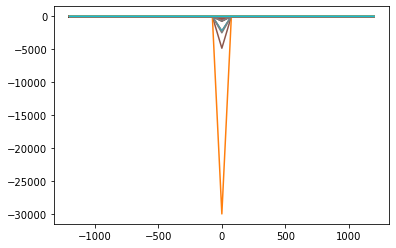

In [214]:
phik = np.log(C)
nuk = np.log(D)

yk = np.array([phik, nuk])

Phi = [phik]
Nu = [nuk]

for n in range(N):
    res = RKF(F, yk, h)
    yk = res[0]
    h = res[1]
    Phi.append(yk[0])
    Nu.append(yk[1])

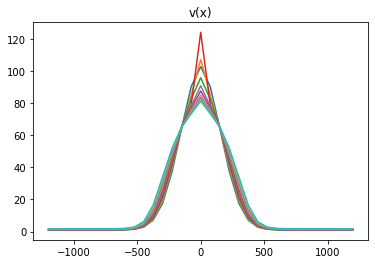

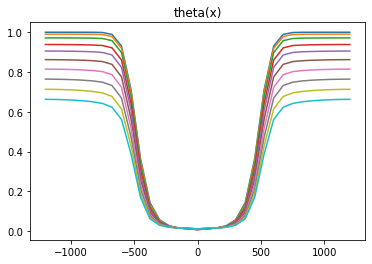

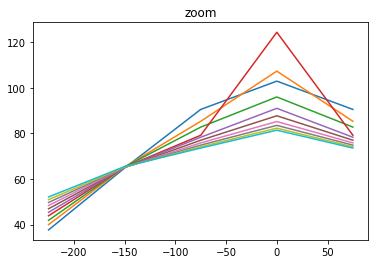

In [216]:
#Affichage

for n in range(1, N, 10):
    plt.plot(x, np.exp(Phi[n]))
plt.title('v(x)')
plt.show()

for n in range(1, N, 10):
    plt.plot(x, np.exp(Nu[n]))
plt.title('theta(x)')
plt.show()

for n in range(1, N, 10):
    plt.plot(x[13:18], np.exp(Phi[n])[13:18])
plt.title('zoom')
plt.show()